In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Saving MERRA-2 Indices in .pkl
### Indices are derived from anomalies from the detrended data and then normalized<br>
### Indices include: EPC1, EPC2, PSA1, PSA2, SAM,  , ASL Rel CP Value, ASL Abs CP Value, ASL CP lon, ASL CP lat
### Now includes Southern Oscillation and Nino3.4 (15Jan2019)
### Indice time periods include: DJF, MAM, JJA, SON, 3- 6- 12- Month Roll, Annual Mean, and 2-7-yr bandpass filter

### 27Nov2018 Update includes improved way to calculate ASL Components


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats
import matplotlib.pyplot as plt

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

##Save figure file path
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size (198001-201712) -- One year less that ERA-Interim


##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'


In [4]:
#For ERA, decode_cf needs to be set to True for proper concatenation on T axis
merra_disk = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(merra_disk)
era_disk = xr.open_dataset(NETCDF_PATH+'/ERA_DATA.nc')
print(era_disk)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 468)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-12-01
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    sst

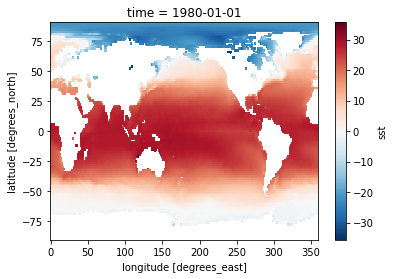

In [5]:
merra_disk.sst[0].plot()

In [6]:
#getting variables in right units 

In [7]:
slp_tmon_merra = merra_disk.msl/100 #hPa
v10_tmon_merra = merra_disk.v10 #in m/s at 10m
u10_tmon_merra = merra_disk.u10 #in m/s at 10m
t2m_tmon_merra = merra_disk.t2m-273.15 #in C
tp_tmon_merra  = merra_disk.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = merra_disk.ci #in [0-1] fraction of sea ice
sst_tmon_merra = merra_disk.sst #SST in C -- taken care of when making the xarray/.nc file

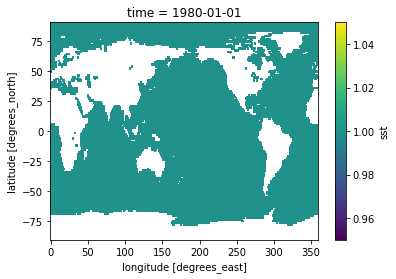

In [8]:
landsea_mask = sst_tmon_merra[0]/sst_tmon_merra[0]
# landsea_mask_coords = xr.DataArray(landsea_mask, coords={'lat': MERRA1_DATA.coords['lat'],'lon': MERRA1_DATA.coords['lon']}, dims=('lat','lon'))
landsea_mask.plot()

## Calculate SAM and PSA1 and PSA2 indices via first 3 EOFs of Southern Hemi SLP Anoms <br>
http://research.jisao.washington.edu/data/aao/slp/ -for SAM<br>
Also see Yu et al 2011 for definition of SAM (AAO) and PSA1 and PSA2
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend the slp in the Southern Hemisphere region (South of 20S)<br>
1) SLP Anomalies are calculated for each calendar month with respect to the 00020101-00491231.  <br>
2) Each grid box is area weighted by the square root of the cosine of the central latitude.<br>
3) The covariance matrix of the area-weighted data is calculated for the grid boxes south of 20S, and the principal component (PC, timeseries ) calculated for that matrix. The first EOF is SAM, the second is PSA1 (Pacific-South American teleconnection, and third is PSA2 - see Yu et al 2011<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>
**Not doing the rest:**<br>
4) The PC is correlated with global SLP anomalies, and that correlation map projected onto the data, including area weighting, to produce a time series for SAM for the entire record. (Not sure how he did this) <br>
5) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>

In [9]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2017-12-01'
# shem_xhi = 
# shem_xlo = 
# shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
# shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [10]:
#params to be set
shem_yhi = -90 #Had to reverse hi and lo lat values for ERA & MERRA
shem_ylo = -20  #Had to reverse hi and lo lat values for ERA & MERRA


In [11]:
slp_shem_tmon_merra = slp_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))
slp_shem_tmon_merra

<xarray.DataArray 'msl' (time: 456, lat: 47, lon: 240)>
array([[[1017.3772 , 1017.0489 , 1016.6532 , ..., 1018.01544,
         1017.8471 , 1017.6412 ],
        [1018.1129 , 1017.80786, 1017.42596, ..., 1018.73096,
         1018.5636 , 1018.36115],
        [1018.806  , 1018.52783, 1018.1726 , ..., 1019.4014 ,
         1019.2422 , 1019.0449 ],
        ...,
        [ 999.406  ,  999.50073,  999.59515, ...,  999.12286,
          999.2166 ,  999.3113 ],
        [ 999.2244 ,  999.2603 ,  999.3063 , ...,  999.1555 ,
          999.17896,  999.20197],
        [ 998.4744 ,  998.4744 ,  998.4744 , ...,  998.4744 ,
          998.4744 ,  998.4744 ]],

       [[1015.63403, 1015.2942 , 1014.91705, ..., 1016.334  ,
         1016.1587 , 1015.92975],
        [1016.43445, 1016.09436, 1015.7118 , ..., 1017.09674,
         1016.9316 , 1016.71686],
        [1017.2199 , 1016.9088 , 1016.53394, ..., 1017.8485 ,
         1017.6785 , 1017.47815],
...
        [ 989.80835,  989.92487,  990.04175, ...,  989.4659 ,
          989.5774 ,  989.6925 ],
        [ 990.46075,  990.51373,  990.57227, ...,  990.3253 ,
          990.3702 ,  990.4153 ],
        [ 990.14484,  990.14484,  990.14484, ...,  990.14484,
          990.14484,  990.14484]],

       [[1017.66736, 1017.33344, 1016.9357 , ..., 1018.4512 ,
         1018.2311 , 1017.9671 ],
        [1018.45807, 1018.1064 , 1017.72144, ..., 1019.2265 ,
         1019.0249 , 1018.764  ],
        [1019.28284, 1018.9344 , 1018.54193, ..., 1019.9871 ,
         1019.8155 , 1019.58984],
        ...,
        [ 992.35333,  992.4121 ,  992.4729 , ...,  992.18994,
          992.2422 ,  992.2969 ],
        [ 993.40955,  993.44525,  993.48474, ...,  993.3186 ,
          993.34827,  993.3786 ],
        [ 993.5281 ,  993.5281 ,  993.5281 , ...,  993.5281 ,
          993.5281 ,  993.5281 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [12]:
#Step 1a)
#Detrend Southern Hem SLPs; use of scipy
#requires remapping back to xr dataArray 
#Returns the detrended slp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(slp_shem_tmon_merra, axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': slp_shem_tmon_merra.coords['time'], 'lat': slp_shem_tmon_merra.coords['lat'],'lon': slp_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

slp_shem_tmon_detrend_merra = aa2

# slp_shem_tmon_detrend_merra[0,:,:].plot() #2D map

In [13]:
#Create SLP Monthly Climatology from detrended data using data from time_lo to time_hi
slp_detrend_shem_climatology_merra = slp_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_detrend_shem_climatology_merra

#slp_detrend_shem_climatology_merra[:,90,24].plot()

In [14]:
#Step 1)
#Find Southern Hemisphere SLP Anoms using the climatology from time_lo to time_hi
slp_anoms_shem_tmon_detrend_merra = slp_shem_tmon_detrend_merra.groupby('time.month') - slp_detrend_shem_climatology_merra
#slp_anoms_shem_tmon_detrend_merra

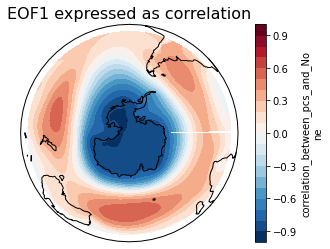

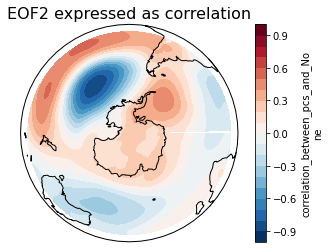

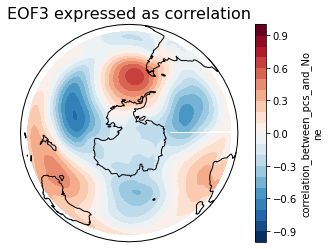

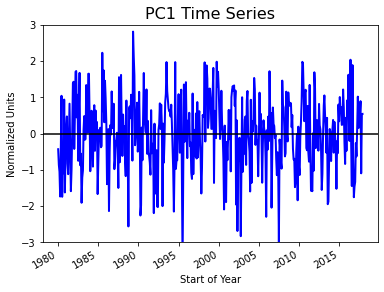

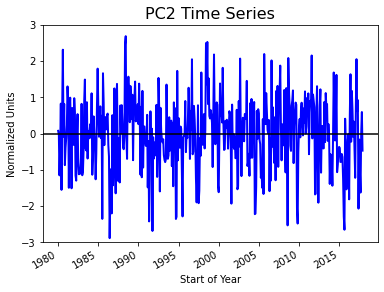

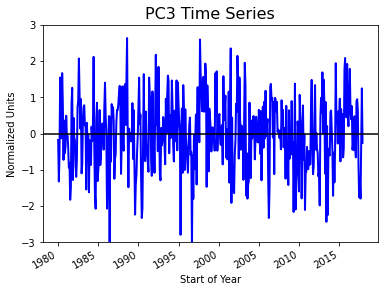

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [15]:
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)

From Marshall and Thompson 2016, look at Fig 3, from this and my work with the PSA1, PSA2, SAM, 
correlations with T2M, PSA2 needs to have sign changes in order to get proper correlation with T2M.
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


# Plot the 2nd PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [16]:
#Step 4, normalize to 0 mean and 1 STD (the eof method actually already did this, so not much change in the time series)
SAM_tmon_merra = pc1[:, 0]
# print(SAM_tmon_merra.mean(),SAM_tmon_merra.std())
norm_SAM_tmon_merra = (SAM_tmon_merra - SAM_tmon_merra.mean())/SAM_tmon_merra.std()
# print(norm_SAM_tmon_merra.mean(),norm_SAM_tmon_merra.std())

PSA1_tmon_merra = pc1[:, 1]
norm_PSA1_tmon_merra = (PSA1_tmon_merra - PSA1_tmon_merra.mean())/PSA1_tmon_merra.std()
# print(norm_PSA1_tmon_merra.mean(),norm_PSA1_tmon_merra.std())

PSA2_tmon_merra = pc1[:, 2]
norm_PSA2_tmon_merra = (PSA2_tmon_merra - PSA2_tmon_merra.mean())/PSA2_tmon_merra.std()
# print(norm_PSA2_tmon_merra.mean(),norm_PSA2_tmon_merra.std())



In [17]:
#For copying to Excel: C:\Users\Paul\Desktop\Tabor\SAM_Trials_with_EOF_from_WASH_U_Definition.xlsx
series = norm_SAM_tmon_merra.to_series()

pd_series = pd.Series.to_frame(series)

# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(pd_series)

In [18]:
#SAM, PSA1, PSA2 indices as pandas dataframe
#NOTE, negative center over AA (eof1), positive center ASL (eof2), negative center AP (eof3)
df_SAM_merra = pd.DataFrame(norm_SAM_tmon_merra.values)
df_SAM_merra.columns = ['SAM']
#df_SAM_merra

df_PSA1_merra = pd.DataFrame(norm_PSA1_tmon_merra.values)*(-1)
df_PSA1_merra.columns = ['PSA1']
#df_PSA1_merra

df_PSA2_merra = pd.DataFrame(norm_PSA2_tmon_merra.values)*(-1)
df_PSA2_merra.columns = ['PSA2']
#df_SAM_merra

df_time_merra = pd.DataFrame(norm_SAM_tmon_merra.coords['time'].values)
df_time_merra.columns = ['time']
#df_time_merra

SAM_PSAs_indices_merra = pd.concat([df_time_merra, df_SAM_merra, df_PSA1_merra, df_PSA2_merra], axis=1)

# SAM_PSAs_indices_merra.to_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')

SAM_PSAs_indices_merra.head(n=5)
#SAM_PSAs_indices_merra.to_csv('Monthly_merra_SAM_PSAs.csv')

,time,SAM,PSA1,PSA2
0,1980-01-01,-0.429369,-0.078547,0.174077
1,1980-02-01,-0.866544,0.031309,1.320172
2,1980-03-01,-1.050691,1.151231,0.593894
3,1980-04-01,-1.737197,0.386887,-1.552102
4,1980-05-01,-0.420486,-0.829418,-0.691180


In [19]:
SAM_PSAs_indices_merra.tail(n=24)

,time,SAM,PSA1,PSA2
432,2016-01-01,0.920186,1.032478,-1.925776
433,2016-02-01,0.563813,0.161963,-0.502688
434,2016-03-01,1.627574,0.012114,-0.206504
435,2016-04-01,-0.187513,1.813865,-0.979638
436,2016-05-01,-0.201621,-0.515184,-1.789272
437,2016-06-01,2.042290,-1.641109,-0.638612
438,2016-07-01,-0.267215,0.221653,-0.399227
439,2016-08-01,-1.446193,-1.180679,-0.760356
440,2016-09-01,1.893810,-0.643905,0.442378
441,2016-10-01,-0.599595,0.090184,0.252188


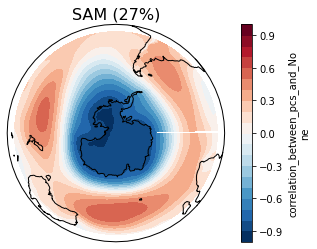

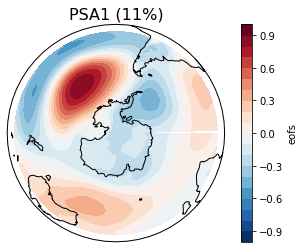

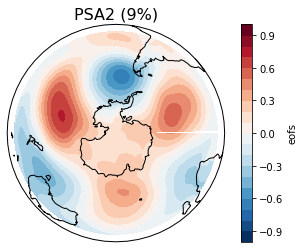

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [20]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign (multiplying PSA2 by -1)
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_sign = eof1[1]*(-1)
psa1_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (11%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_sign = eof1[2]*(-1)
psa2_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)


# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 2].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC3 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig02_merra_sam_and_psas_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

## Setting the EOFs to the Appropriate SAM, PSA1, or PSA2 designation with the appropriate sign

In [21]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""


#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_merra.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)


sam_eof_merra  = eof1[0]
psa1_eof_merra = eof1[1]*(-1)
psa2_eof_merra = eof1[2]*(-1)



<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.2697225 , 0.11021259, 0.09389763], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


Text(0.5, 1.0, 'PSA2 (9%)')

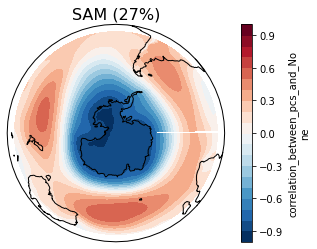

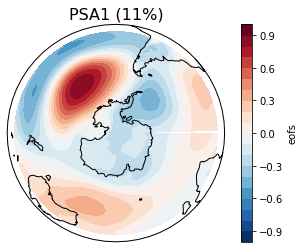

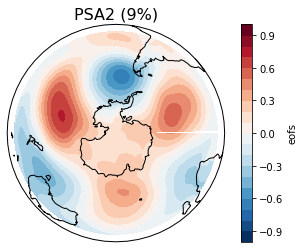

In [22]:
# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
sam_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (27%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa1_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (11%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
psa2_eof_merra.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)

In [23]:
sam_eof_cyclic_merra, lons = add_cyclic_point(sam_eof_merra.values, sam_eof_merra.coords['lon'].values, axis=-1)
psa1_eof_cyclic_merra, lons = add_cyclic_point(psa1_eof_merra.values, psa1_eof_merra.coords['lon'].values, axis=-1)
psa2_eof_cyclic_merra, lons = add_cyclic_point(psa2_eof_merra.values, psa2_eof_merra.coords['lon'].values, axis=-1)
lon_orig_merra, lat_orig_merra = np.meshgrid(sam_eof_merra.coords['lon'].values, sam_eof_merra.coords['lat'].values)
lon_cyclic_merra, lat_cyclic_merra = np.meshgrid(lons, sam_eof_merra.coords['lat'].values)

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


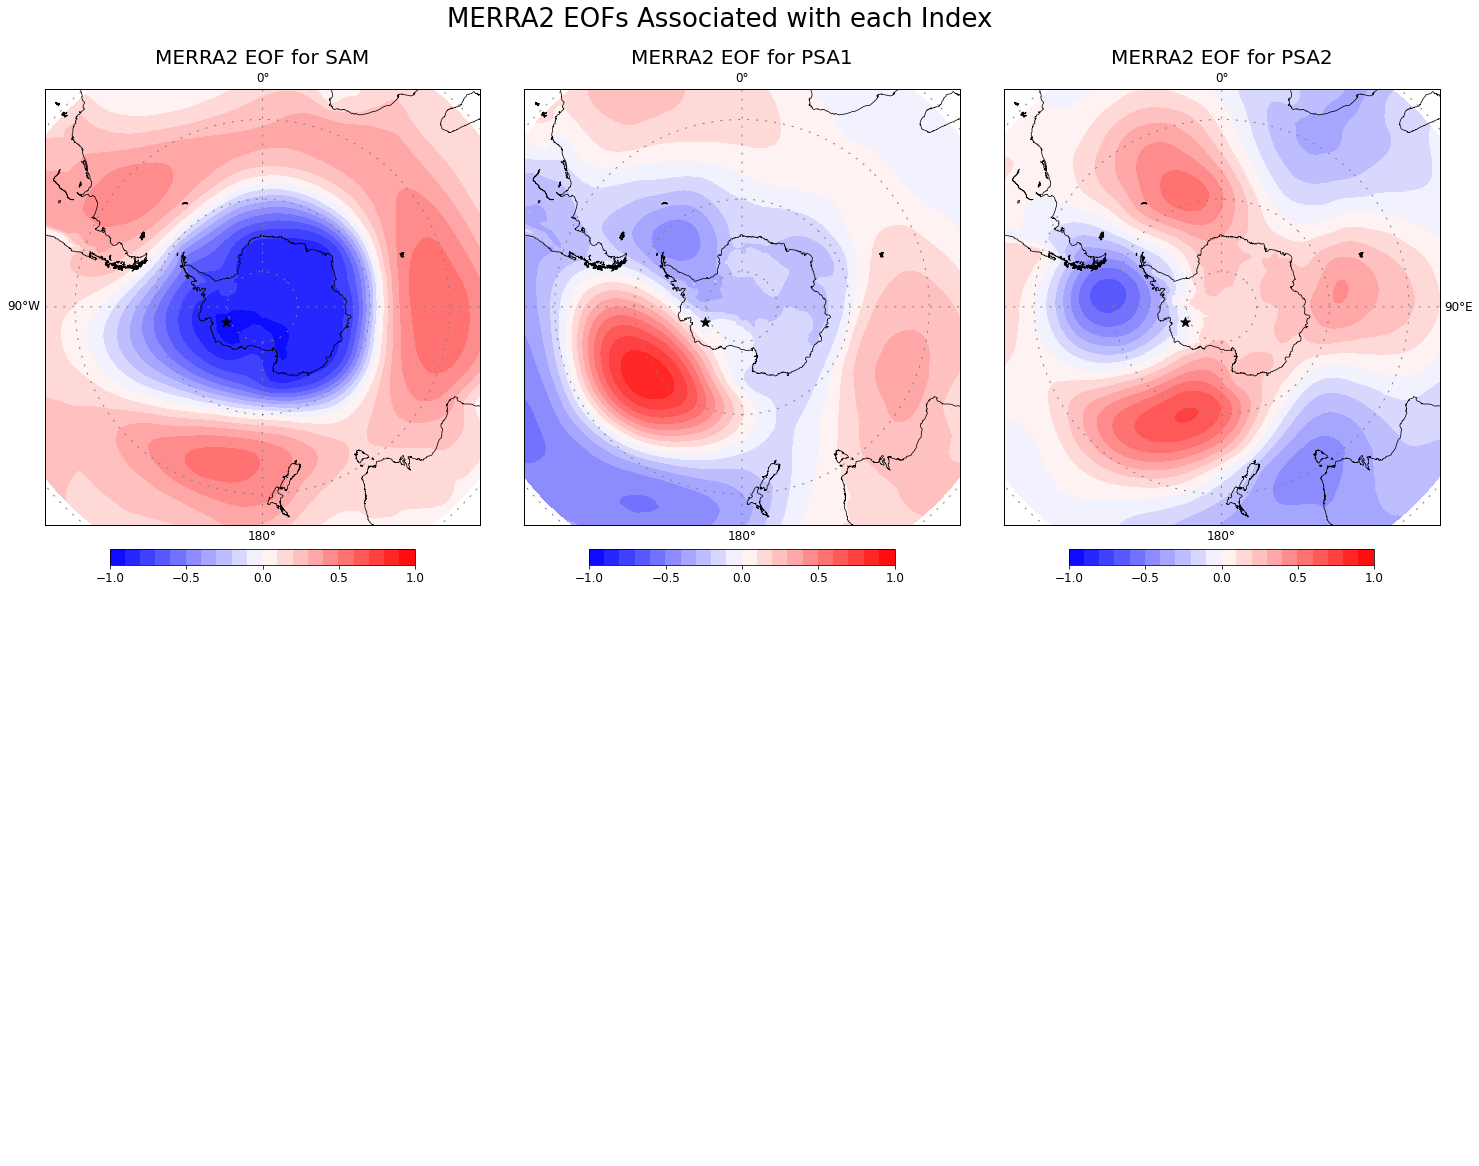

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index', fontsize=26, y=.925)


parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_No_SLP.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

## Turn monthly data into Seasonal and Annual mean Anomalies (Raw Data (ie, not detrended or seas mean-less)



In [25]:
#params to be set
time_lo     = '1702-01-01' #Skipped first year = JUST FOR iCESM Data!!!
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = 90 #Keeping full globe for iCESM and MERRA IVT comparison
shem_ylo = -90  


In [26]:
# time_coords = slp_tmon_ctrl.sel(time=slice(time_lo,time_hi)).coords['time']
# lat_coords  = slp_tmon_ctrl.sel(lat=slice(shem_ylo,shem_yhi)).coords['lat']
# lon_coords  = slp_tmon_ctrl.coords['lon']

# #iCESM IVT data with new time coords

# SLP_tmon_raw_ctrl = xr.DataArray(slp_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))


#MERRA2 variables don't need changes

SLP_tmon_raw_merra = slp_tmon_merra
U10_tmon_raw_merra = u10_tmon_merra
V10_tmon_raw_merra = v10_tmon_merra

In [27]:

print(SLP_tmon_raw_merra.shape)


(456, 121, 240)


# In this notebook, I am detrending the variables -- Does not appear to impact the results very much

In [28]:
#After detrending, add the mean back to the detrended values (detrending centers values about 0)
#iCESM variables

# mean = SLP_tmon_raw_ctrl.mean(axis=0)
# aa1 = signal.detrend(SLP_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# aa2 = xr.DataArray(aa1, coords={'time': SLP_tmon_raw_ctrl.coords['time'], 'lat': SLP_tmon_raw_ctrl.coords['lat'],'lon': SLP_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
# SLP_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean

#MERRA2 variables

mean = SLP_tmon_raw_merra.mean(axis=0)
aa1 = signal.detrend(SLP_tmon_raw_merra.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': SLP_tmon_raw_merra.coords['time'], 'lat': SLP_tmon_raw_merra.coords['lat'],'lon': SLP_tmon_raw_merra.coords['lon']}, dims=('time','lat','lon'))
SLP_tmon_detrended_merra = aa2.where(aa2 != 0.00000, np.nan) + mean

mean = U10_tmon_raw_merra.mean(axis=0)
aa1 = signal.detrend(U10_tmon_raw_merra.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': U10_tmon_raw_merra.coords['time'], 'lat': U10_tmon_raw_merra.coords['lat'],'lon': U10_tmon_raw_merra.coords['lon']}, dims=('time','lat','lon'))
U10_tmon_detrended_merra = aa2.where(aa2 != 0.00000, np.nan) + mean

mean = V10_tmon_raw_merra.mean(axis=0)
aa1 = signal.detrend(V10_tmon_raw_merra.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': V10_tmon_raw_merra.coords['time'], 'lat': V10_tmon_raw_merra.coords['lat'],'lon': V10_tmon_raw_merra.coords['lon']}, dims=('time','lat','lon'))
V10_tmon_detrended_merra = aa2.where(aa2 != 0.00000, np.nan) + mean

In [29]:
#IVT, TPW, SLP fields in seasonal and annual means
#iCESM


# #SLP
# SLP_tmon_detrended_rolls_ctrl = SLP_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
# djf_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[12::12,:]
# mam_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[3::12,:]
# jja_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[6::12,:]
# son_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[9::12,:]
# ann_mean_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')



#MERRA2
#SLP
SLP_tmon_detrended_rolls_merra = SLP_tmon_detrended_merra.rolling(time=3, min_periods=3, center=True).mean()
djf_SLP_detrended_merra = SLP_tmon_detrended_rolls_merra[12::12,:]
mam_SLP_detrended_merra = SLP_tmon_detrended_rolls_merra[3::12,:]
jja_SLP_detrended_merra = SLP_tmon_detrended_rolls_merra[6::12,:]
son_SLP_detrended_merra = SLP_tmon_detrended_rolls_merra[9::12,:]
ann_mean_SLP_detrended_merra = SLP_tmon_detrended_rolls_merra.groupby('time.year').mean('time')

#U10
U10_tmon_detrended_rolls_merra = U10_tmon_detrended_merra.rolling(time=3, min_periods=3, center=True).mean()
djf_U10_detrended_merra = U10_tmon_detrended_rolls_merra[12::12,:]
mam_U10_detrended_merra = U10_tmon_detrended_rolls_merra[3::12,:]
jja_U10_detrended_merra = U10_tmon_detrended_rolls_merra[6::12,:]
son_U10_detrended_merra = U10_tmon_detrended_rolls_merra[9::12,:]
ann_mean_U10_detrended_merra = U10_tmon_detrended_rolls_merra.groupby('time.year').mean('time')

#V10
V10_tmon_detrended_rolls_merra = V10_tmon_detrended_merra.rolling(time=3, min_periods=3, center=True).mean()
djf_V10_detrended_merra = V10_tmon_detrended_rolls_merra[12::12,:]
mam_V10_detrended_merra = V10_tmon_detrended_rolls_merra[3::12,:]
jja_V10_detrended_merra = V10_tmon_detrended_rolls_merra[6::12,:]
son_V10_detrended_merra = V10_tmon_detrended_rolls_merra[9::12,:]
ann_mean_V10_detrended_merra = V10_tmon_detrended_rolls_merra.groupby('time.year').mean('time')

## Find quartiles for SAM for both iCESM and MERRA2

In [30]:
# SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# # SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

# SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
# print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))

In [31]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

# d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
# SAM_djf_mean_ctrl = pd.DataFrame(data=d)
# # SAM_djf_mean_ctrl

# d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
# SAM_mam_mean_ctrl = pd.DataFrame(data=d)
# # SAM_mam_mean_ctrl

# d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
# SAM_jja_mean_ctrl = pd.DataFrame(data=d)
# # SAM_jja_mean_ctrl

# d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
# SAM_son_mean_ctrl = pd.DataFrame(data=d)
# # SAM_son_mean_ctrl

# d = {'SAM': SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna()),1)}
# SAM_ann_mean_ctrl = pd.DataFrame(data=d)
# # SAM_ann_mean_ctrl


# #create list of indices representing the upper/lower quartiles of 'SAM'
# #Note, head is lower (sorted from low to high)
# SAM_djf_mean_lower_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_djf_mean_lower_ctrl
# SAM_djf_mean_upper_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_djf_mean_upper_ctrl

# SAM_mam_mean_lower_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_mam_mean_lower_ctrl
# SAM_mam_mean_upper_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_mam_mean_upper_ctrl

# SAM_jja_mean_lower_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_jja_mean_lower_ctrl
# SAM_jja_mean_upper_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_jja_mean_upper_ctrl

# SAM_son_mean_lower_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_son_mean_lower_ctrl
# SAM_son_mean_upper_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_son_mean_upper_ctrl

# SAM_ann_mean_lower_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_ann_mean_lower_ctrl
# SAM_ann_mean_upper_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # SAM_ann_mean_upper_ctrl

In [32]:
SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_merra.head(n=5)

SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# SAM_PSAs_ann_mean_indices_merra.head(n=5)

In [33]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_merra = pd.DataFrame(data=d)
# SAM_djf_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_merra = pd.DataFrame(data=d)
# SAM_mam_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_merra = pd.DataFrame(data=d)
# SAM_jja_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
SAM_son_mean_merra = pd.DataFrame(data=d)
# SAM_son_mean_merra

d = {'SAM': SAM_PSAs_ann_mean_indices_merra.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.SAM.dropna()),1)}
SAM_ann_mean_merra = pd.DataFrame(data=d)
# SAM_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_merra
SAM_djf_mean_upper_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_merra

SAM_mam_mean_lower_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_merra
SAM_mam_mean_upper_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_merra

SAM_jja_mean_lower_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_merra
SAM_jja_mean_upper_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_merra

SAM_son_mean_lower_merra = SAM_son_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_merra
SAM_son_mean_upper_merra = SAM_son_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_merra

SAM_ann_mean_lower_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_merra
SAM_ann_mean_upper_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_merra

In [34]:
# print(SAM_mam_mean_lower_ctrl)
print(SAM_mam_mean_lower_merra)

[22, 10, 12, 0, 6, 27, 1, 14, 28, 11]


## Select the times of the field variable dependent upon quartile and the indice 

In [35]:
#Select the times of the field variable dependent upon quartile and the indice 

# #DJF, (both datasets already at s=47, so no need to crop the time series)
# djf_slp_w_upper_SAM_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
# djf_slp_w_lower_SAM_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# # djf_slp_w_upper_SAM_detrended_ctrl
# # djf_slp_w_lower_SAM_detrended_ctrl

# #mam
# mam_slp_w_upper_SAM_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
# mam_slp_w_lower_SAM_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# # mam_slp_w_upper_SAM_detrended_ctrl
# # mam_slp_w_lower_SAM_detrended_ctrl

# #jja
# jja_slp_w_upper_SAM_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
# jja_slp_w_lower_SAM_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# # jja_slp_w_upper_SAM_detrended_ctrl
# # jja_slp_w_lower_SAM_detrended_ctrl

# #son
# son_slp_w_upper_SAM_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
# son_slp_w_lower_SAM_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
# son_slp_w_upper_SAM_detrended_ctrl
# # son_slp_w_lower_SAM_detrended_ctrl

# #ann mean
# ann_mean_slp_w_upper_SAM_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
# ann_mean_slp_w_lower_SAM_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)
# # ann_mean_slp_w_upper_SAM_detrended_ctrl
# # ann_mean_slp_w_lower_SAM_detrended_ctrl


In [36]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_slp_w_upper_SAM_detrended_merra = djf_SLP_detrended_merra.isel(time = SAM_djf_mean_upper_merra)
djf_slp_w_lower_SAM_detrended_merra = djf_SLP_detrended_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_slp_w_upper_SAM_detrended_merra
# djf_slp_w_lower_SAM_detrended_merra

#mam
mam_slp_w_upper_SAM_detrended_merra = mam_SLP_detrended_merra.isel(time = SAM_mam_mean_upper_merra)
mam_slp_w_lower_SAM_detrended_merra = mam_SLP_detrended_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_slp_w_upper_SAM_detrended_merra
# mam_slp_w_lower_SAM_detrended_merra

#jja
jja_slp_w_upper_SAM_detrended_merra = jja_SLP_detrended_merra.isel(time = SAM_jja_mean_upper_merra)
jja_slp_w_lower_SAM_detrended_merra = jja_SLP_detrended_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_slp_w_upper_SAM_detrended_merra
# jja_slp_w_lower_SAM_detrended_merra

#son
son_slp_w_upper_SAM_detrended_merra = son_SLP_detrended_merra.isel(time = SAM_son_mean_upper_merra)
son_slp_w_lower_SAM_detrended_merra = son_SLP_detrended_merra.isel(time = SAM_son_mean_lower_merra)
son_slp_w_upper_SAM_detrended_merra
# son_slp_w_lower_SAM_detrended_merra

#ann mean
ann_mean_slp_w_upper_SAM_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = SAM_ann_mean_upper_merra)
ann_mean_slp_w_lower_SAM_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = SAM_ann_mean_lower_merra)
# ann_mean_slp_w_upper_SAM_detrended_merra
# ann_mean_slp_w_lower_SAM_detrended_merra



#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_u10_w_upper_SAM_detrended_merra = djf_U10_detrended_merra.isel(time = SAM_djf_mean_upper_merra)
djf_u10_w_lower_SAM_detrended_merra = djf_U10_detrended_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_u10_w_upper_SAM_detrended_merra
# djf_u10_w_lower_SAM_detrended_merra

#mam
mam_u10_w_upper_SAM_detrended_merra = mam_U10_detrended_merra.isel(time = SAM_mam_mean_upper_merra)
mam_u10_w_lower_SAM_detrended_merra = mam_U10_detrended_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_u10_w_upper_SAM_detrended_merra
# mam_u10_w_lower_SAM_detrended_merra

#jja
jja_u10_w_upper_SAM_detrended_merra = jja_U10_detrended_merra.isel(time = SAM_jja_mean_upper_merra)
jja_u10_w_lower_SAM_detrended_merra = jja_U10_detrended_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_u10_w_upper_SAM_detrended_merra
# jja_u10_w_lower_SAM_detrended_merra

#son
son_u10_w_upper_SAM_detrended_merra = son_U10_detrended_merra.isel(time = SAM_son_mean_upper_merra)
son_u10_w_lower_SAM_detrended_merra = son_U10_detrended_merra.isel(time = SAM_son_mean_lower_merra)
son_u10_w_upper_SAM_detrended_merra
# son_u10_w_lower_SAM_detrended_merra

#ann mean
ann_mean_u10_w_upper_SAM_detrended_merra = ann_mean_U10_detrended_merra.isel(year = SAM_ann_mean_upper_merra)
ann_mean_u10_w_lower_SAM_detrended_merra = ann_mean_U10_detrended_merra.isel(year = SAM_ann_mean_lower_merra)
# ann_mean_u10_w_upper_SAM_detrended_merra
# ann_mean_u10_w_lower_SAM_detrended_merra


#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_v10_w_upper_SAM_detrended_merra = djf_V10_detrended_merra.isel(time = SAM_djf_mean_upper_merra)
djf_v10_w_lower_SAM_detrended_merra = djf_V10_detrended_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_v10_w_upper_SAM_detrended_merra
# djf_v10_w_lower_SAM_detrended_merra

#mam
mam_v10_w_upper_SAM_detrended_merra = mam_V10_detrended_merra.isel(time = SAM_mam_mean_upper_merra)
mam_v10_w_lower_SAM_detrended_merra = mam_V10_detrended_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_v10_w_upper_SAM_detrended_merra
# mam_v10_w_lower_SAM_detrended_merra

#jja
jja_v10_w_upper_SAM_detrended_merra = jja_V10_detrended_merra.isel(time = SAM_jja_mean_upper_merra)
jja_v10_w_lower_SAM_detrended_merra = jja_V10_detrended_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_v10_w_upper_SAM_detrended_merra
# jja_v10_w_lower_SAM_detrended_merra

#son
son_v10_w_upper_SAM_detrended_merra = son_V10_detrended_merra.isel(time = SAM_son_mean_upper_merra)
son_v10_w_lower_SAM_detrended_merra = son_V10_detrended_merra.isel(time = SAM_son_mean_lower_merra)
son_v10_w_upper_SAM_detrended_merra
# son_v10_w_lower_SAM_detrended_merra

#ann mean
ann_mean_v10_w_upper_SAM_detrended_merra = ann_mean_V10_detrended_merra.isel(year = SAM_ann_mean_upper_merra)
ann_mean_v10_w_lower_SAM_detrended_merra = ann_mean_V10_detrended_merra.isel(year = SAM_ann_mean_lower_merra)
# ann_mean_v10_w_upper_SAM_detrended_merra
# ann_mean_v10_w_lower_SAM_detrended_merra

## Find quartiles for PSA1 for both iCESM and MERRA2

In [37]:
# SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# # SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

# SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
# print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))

In [38]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

# d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
# PSA1_djf_mean_ctrl = pd.DataFrame(data=d)
# # PSA1_djf_mean_ctrl

# d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
# PSA1_mam_mean_ctrl = pd.DataFrame(data=d)
# # PSA1_mam_mean_ctrl

# d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
# PSA1_jja_mean_ctrl = pd.DataFrame(data=d)
# # PSA1_jja_mean_ctrl

# d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
# PSA1_son_mean_ctrl = pd.DataFrame(data=d)
# # PSA1_son_mean_ctrl

# d = {'PSA1': SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna()),1)}
# PSA1_ann_mean_ctrl = pd.DataFrame(data=d)
# # PSA1_ann_mean_ctrl


# #create list of indices representing the upper/lower quartiles of 'PSA1'
# #Note, head is lower (sorted from low to high)
# PSA1_djf_mean_lower_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_djf_mean_lower_ctrl
# PSA1_djf_mean_upper_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_djf_mean_upper_ctrl

# PSA1_mam_mean_lower_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_mam_mean_lower_ctrl
# PSA1_mam_mean_upper_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_mam_mean_upper_ctrl

# PSA1_jja_mean_lower_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_jja_mean_lower_ctrl
# PSA1_jja_mean_upper_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_jja_mean_upper_ctrl

# PSA1_son_mean_lower_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_son_mean_lower_ctrl
# PSA1_son_mean_upper_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_son_mean_upper_ctrl

# PSA1_ann_mean_lower_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_ann_mean_lower_ctrl
# PSA1_ann_mean_upper_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA1_ann_mean_upper_ctrl

In [39]:
# SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# # SAM_PSAs_seas_mean_indices_merra.head(n=5)

# SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# # SAM_PSAs_ann_mean_indices_merra.head(n=5)

In [40]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_merra = pd.DataFrame(data=d)
# PSA1_djf_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_merra = pd.DataFrame(data=d)
# PSA1_mam_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_merra = pd.DataFrame(data=d)
# PSA1_jja_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_merra = pd.DataFrame(data=d)
# PSA1_son_mean_merra

d = {'PSA1': SAM_PSAs_ann_mean_indices_merra.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA1.dropna()),1)}
PSA1_ann_mean_merra = pd.DataFrame(data=d)
# PSA1_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_merra
PSA1_djf_mean_upper_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_merra

PSA1_mam_mean_lower_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_merra
PSA1_mam_mean_upper_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_merra

PSA1_jja_mean_lower_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_merra
PSA1_jja_mean_upper_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_merra

PSA1_son_mean_lower_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_merra
PSA1_son_mean_upper_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_merra

PSA1_ann_mean_lower_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_merra
PSA1_ann_mean_upper_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_merra

In [41]:
# print(PSA1_mam_mean_lower_ctrl)
print(PSA1_mam_mean_lower_merra)

[37, 20, 27, 16, 8, 3, 33, 32, 30, 29]


## Select the times of the field variable dependent upon quartile and the indice 

In [42]:
#Select the times of the field variable dependent upon quartile and the indice 

# #DJF, (both datasets already at s=47, so no need to crop the time series)
# djf_slp_w_upper_PSA1_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
# djf_slp_w_lower_PSA1_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# # djf_slp_w_upper_PSA1_detrended_ctrl
# # djf_slp_w_lower_PSA1_detrended_ctrl

# #mam
# mam_slp_w_upper_PSA1_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
# mam_slp_w_lower_PSA1_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# # mam_slp_w_upper_PSA1_detrended_ctrl
# # mam_slp_w_lower_PSA1_detrended_ctrl

# #jja
# jja_slp_w_upper_PSA1_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
# jja_slp_w_lower_PSA1_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# # jja_slp_w_upper_PSA1_detrended_ctrl
# # jja_slp_w_lower_PSA1_detrended_ctrl

# #son
# son_slp_w_upper_PSA1_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
# son_slp_w_lower_PSA1_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
# son_slp_w_upper_PSA1_detrended_ctrl
# # son_slp_w_lower_PSA1_detrended_ctrl

# #ann mean
# ann_mean_slp_w_upper_PSA1_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = PSA1_ann_mean_upper_ctrl)
# ann_mean_slp_w_lower_PSA1_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = PSA1_ann_mean_lower_ctrl)
# # ann_mean_slp_w_upper_PSA1_detrended_ctrl
# # ann_mean_slp_w_lower_PSA1_detrended_ctrl


In [43]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_slp_w_upper_PSA1_detrended_merra = djf_SLP_detrended_merra.isel(time = PSA1_djf_mean_upper_merra)
djf_slp_w_lower_PSA1_detrended_merra = djf_SLP_detrended_merra.isel(time = PSA1_djf_mean_lower_merra)
# djf_slp_w_upper_PSA1_detrended_merra
# djf_slp_w_lower_PSA1_detrended_merra

#mam
mam_slp_w_upper_PSA1_detrended_merra = mam_SLP_detrended_merra.isel(time = PSA1_mam_mean_upper_merra)
mam_slp_w_lower_PSA1_detrended_merra = mam_SLP_detrended_merra.isel(time = PSA1_mam_mean_lower_merra)
# mam_slp_w_upper_PSA1_detrended_merra
# mam_slp_w_lower_PSA1_detrended_merra

#jja
jja_slp_w_upper_PSA1_detrended_merra = jja_SLP_detrended_merra.isel(time = PSA1_jja_mean_upper_merra)
jja_slp_w_lower_PSA1_detrended_merra = jja_SLP_detrended_merra.isel(time = PSA1_jja_mean_lower_merra)
# jja_slp_w_upper_PSA1_detrended_merra
# jja_slp_w_lower_PSA1_detrended_merra

#son
son_slp_w_upper_PSA1_detrended_merra = son_SLP_detrended_merra.isel(time = PSA1_son_mean_upper_merra)
son_slp_w_lower_PSA1_detrended_merra = son_SLP_detrended_merra.isel(time = PSA1_son_mean_lower_merra)
son_slp_w_upper_PSA1_detrended_merra
# son_slp_w_lower_PSA1_detrended_merra

#ann mean
ann_mean_slp_w_upper_PSA1_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = PSA1_ann_mean_upper_merra)
ann_mean_slp_w_lower_PSA1_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = PSA1_ann_mean_lower_merra)
# ann_mean_slp_w_upper_PSA1_detrended_merra
# ann_mean_slp_w_lower_PSA1_detrended_merra



#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_u10_w_upper_PSA1_detrended_merra = djf_U10_detrended_merra.isel(time = PSA1_djf_mean_upper_merra)
djf_u10_w_lower_PSA1_detrended_merra = djf_U10_detrended_merra.isel(time = PSA1_djf_mean_lower_merra)
# djf_u10_w_upper_PSA1_detrended_merra
# djf_u10_w_lower_PSA1_detrended_merra

#mam
mam_u10_w_upper_PSA1_detrended_merra = mam_U10_detrended_merra.isel(time = PSA1_mam_mean_upper_merra)
mam_u10_w_lower_PSA1_detrended_merra = mam_U10_detrended_merra.isel(time = PSA1_mam_mean_lower_merra)
# mam_u10_w_upper_PSA1_detrended_merra
# mam_u10_w_lower_PSA1_detrended_merra

#jja
jja_u10_w_upper_PSA1_detrended_merra = jja_U10_detrended_merra.isel(time = PSA1_jja_mean_upper_merra)
jja_u10_w_lower_PSA1_detrended_merra = jja_U10_detrended_merra.isel(time = PSA1_jja_mean_lower_merra)
# jja_u10_w_upper_PSA1_detrended_merra
# jja_u10_w_lower_PSA1_detrended_merra

#son
son_u10_w_upper_PSA1_detrended_merra = son_U10_detrended_merra.isel(time = PSA1_son_mean_upper_merra)
son_u10_w_lower_PSA1_detrended_merra = son_U10_detrended_merra.isel(time = PSA1_son_mean_lower_merra)
son_u10_w_upper_PSA1_detrended_merra
# son_u10_w_lower_PSA1_detrended_merra

#ann mean
ann_mean_u10_w_upper_PSA1_detrended_merra = ann_mean_U10_detrended_merra.isel(year = PSA1_ann_mean_upper_merra)
ann_mean_u10_w_lower_PSA1_detrended_merra = ann_mean_U10_detrended_merra.isel(year = PSA1_ann_mean_lower_merra)
# ann_mean_u10_w_upper_PSA1_detrended_merra
# ann_mean_u10_w_lower_PSA1_detrended_merra


#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_v10_w_upper_PSA1_detrended_merra = djf_V10_detrended_merra.isel(time = PSA1_djf_mean_upper_merra)
djf_v10_w_lower_PSA1_detrended_merra = djf_V10_detrended_merra.isel(time = PSA1_djf_mean_lower_merra)
# djf_v10_w_upper_PSA1_detrended_merra
# djf_v10_w_lower_PSA1_detrended_merra

#mam
mam_v10_w_upper_PSA1_detrended_merra = mam_V10_detrended_merra.isel(time = PSA1_mam_mean_upper_merra)
mam_v10_w_lower_PSA1_detrended_merra = mam_V10_detrended_merra.isel(time = PSA1_mam_mean_lower_merra)
# mam_v10_w_upper_PSA1_detrended_merra
# mam_v10_w_lower_PSA1_detrended_merra

#jja
jja_v10_w_upper_PSA1_detrended_merra = jja_V10_detrended_merra.isel(time = PSA1_jja_mean_upper_merra)
jja_v10_w_lower_PSA1_detrended_merra = jja_V10_detrended_merra.isel(time = PSA1_jja_mean_lower_merra)
# jja_v10_w_upper_PSA1_detrended_merra
# jja_v10_w_lower_PSA1_detrended_merra

#son
son_v10_w_upper_PSA1_detrended_merra = son_V10_detrended_merra.isel(time = PSA1_son_mean_upper_merra)
son_v10_w_lower_PSA1_detrended_merra = son_V10_detrended_merra.isel(time = PSA1_son_mean_lower_merra)
son_v10_w_upper_PSA1_detrended_merra
# son_v10_w_lower_PSA1_detrended_merra

#ann mean
ann_mean_v10_w_upper_PSA1_detrended_merra = ann_mean_V10_detrended_merra.isel(year = PSA1_ann_mean_upper_merra)
ann_mean_v10_w_lower_PSA1_detrended_merra = ann_mean_V10_detrended_merra.isel(year = PSA1_ann_mean_lower_merra)
# ann_mean_v10_w_upper_PSA1_detrended_merra
# ann_mean_v10_w_lower_PSA1_detrended_merra


## Find quartiles for PSA2 for both iCESM and MERRA2

In [44]:
# SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# # SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

# SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
# print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))

In [45]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

# d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
# PSA2_djf_mean_ctrl = pd.DataFrame(data=d)
# # PSA2_djf_mean_ctrl

# d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
# PSA2_mam_mean_ctrl = pd.DataFrame(data=d)
# # PSA2_mam_mean_ctrl

# d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
# PSA2_jja_mean_ctrl = pd.DataFrame(data=d)
# # PSA2_jja_mean_ctrl

# d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
# PSA2_son_mean_ctrl = pd.DataFrame(data=d)
# # PSA2_son_mean_ctrl

# d = {'PSA2': SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna()),1)}
# PSA2_ann_mean_ctrl = pd.DataFrame(data=d)
# # PSA2_ann_mean_ctrl


# #create list of indices representing the upper/lower quartiles of 'PSA2'
# #Note, head is lower (sorted from low to high)
# PSA2_djf_mean_lower_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_djf_mean_lower_ctrl
# PSA2_djf_mean_upper_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_djf_mean_upper_ctrl

# PSA2_mam_mean_lower_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_mam_mean_lower_ctrl
# PSA2_mam_mean_upper_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_mam_mean_upper_ctrl

# PSA2_jja_mean_lower_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_jja_mean_lower_ctrl
# PSA2_jja_mean_upper_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_jja_mean_upper_ctrl

# PSA2_son_mean_lower_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_son_mean_lower_ctrl
# PSA2_son_mean_upper_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_son_mean_upper_ctrl

# PSA2_ann_mean_lower_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_ann_mean_lower_ctrl
# PSA2_ann_mean_upper_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# # PSA2_ann_mean_upper_ctrl

In [46]:
# SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# # SAM_PSAs_seas_mean_indices_merra.head(n=5)

# SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# # SAM_PSAs_ann_mean_indices_merra.head(n=5)

In [47]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_merra = pd.DataFrame(data=d)
# PSA2_djf_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_merra = pd.DataFrame(data=d)
# PSA2_mam_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_merra = pd.DataFrame(data=d)
# PSA2_jja_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_merra = pd.DataFrame(data=d)
# PSA2_son_mean_merra

d = {'PSA2': SAM_PSAs_ann_mean_indices_merra.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA2.dropna()),1)}
PSA2_ann_mean_merra = pd.DataFrame(data=d)
# PSA2_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_merra
PSA2_djf_mean_upper_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_merra

PSA2_mam_mean_lower_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_merra
PSA2_mam_mean_upper_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_merra

PSA2_jja_mean_lower_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_merra
PSA2_jja_mean_upper_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_merra

PSA2_son_mean_lower_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_merra
PSA2_son_mean_upper_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_merra

PSA2_ann_mean_lower_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_merra
PSA2_ann_mean_upper_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_merra

In [48]:
# print(PSA2_mam_mean_lower_ctrl)
print(PSA2_mam_mean_lower_merra)

[23, 22, 18, 36, 12, 37, 8, 14, 3, 0]


## Select the times of the field variable dependent upon quartile and the indice 

In [49]:
#Select the times of the field variable dependent upon quartile and the indice 

# #DJF, (both datasets already at s=47, so no need to crop the time series)
# djf_slp_w_upper_PSA2_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = PSA2_djf_mean_upper_ctrl)
# djf_slp_w_lower_PSA2_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = PSA2_djf_mean_lower_ctrl)
# # djf_slp_w_upper_PSA2_detrended_ctrl
# # djf_slp_w_lower_PSA2_detrended_ctrl

# #mam
# mam_slp_w_upper_PSA2_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = PSA2_mam_mean_upper_ctrl)
# mam_slp_w_lower_PSA2_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = PSA2_mam_mean_lower_ctrl)
# # mam_slp_w_upper_PSA2_detrended_ctrl
# # mam_slp_w_lower_PSA2_detrended_ctrl

# #jja
# jja_slp_w_upper_PSA2_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = PSA2_jja_mean_upper_ctrl)
# jja_slp_w_lower_PSA2_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = PSA2_jja_mean_lower_ctrl)
# # jja_slp_w_upper_PSA2_detrended_ctrl
# # jja_slp_w_lower_PSA2_detrended_ctrl

# #son
# son_slp_w_upper_PSA2_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = PSA2_son_mean_upper_ctrl)
# son_slp_w_lower_PSA2_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = PSA2_son_mean_lower_ctrl)
# son_slp_w_upper_PSA2_detrended_ctrl
# # son_slp_w_lower_PSA2_detrended_ctrl

# #ann mean
# ann_mean_slp_w_upper_PSA2_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = PSA2_ann_mean_upper_ctrl)
# ann_mean_slp_w_lower_PSA2_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = PSA2_ann_mean_lower_ctrl)
# # ann_mean_slp_w_upper_PSA2_detrended_ctrl
# # ann_mean_slp_w_lower_PSA2_detrended_ctrl


In [50]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_slp_w_upper_PSA2_detrended_merra = djf_SLP_detrended_merra.isel(time = PSA2_djf_mean_upper_merra)
djf_slp_w_lower_PSA2_detrended_merra = djf_SLP_detrended_merra.isel(time = PSA2_djf_mean_lower_merra)
# djf_slp_w_upper_PSA2_detrended_merra
# djf_slp_w_lower_PSA2_detrended_merra

#mam
mam_slp_w_upper_PSA2_detrended_merra = mam_SLP_detrended_merra.isel(time = PSA2_mam_mean_upper_merra)
mam_slp_w_lower_PSA2_detrended_merra = mam_SLP_detrended_merra.isel(time = PSA2_mam_mean_lower_merra)
# mam_slp_w_upper_PSA2_detrended_merra
# mam_slp_w_lower_PSA2_detrended_merra

#jja
jja_slp_w_upper_PSA2_detrended_merra = jja_SLP_detrended_merra.isel(time = PSA2_jja_mean_upper_merra)
jja_slp_w_lower_PSA2_detrended_merra = jja_SLP_detrended_merra.isel(time = PSA2_jja_mean_lower_merra)
# jja_slp_w_upper_PSA2_detrended_merra
# jja_slp_w_lower_PSA2_detrended_merra

#son
son_slp_w_upper_PSA2_detrended_merra = son_SLP_detrended_merra.isel(time = PSA2_son_mean_upper_merra)
son_slp_w_lower_PSA2_detrended_merra = son_SLP_detrended_merra.isel(time = PSA2_son_mean_lower_merra)
son_slp_w_upper_PSA2_detrended_merra
# son_slp_w_lower_PSA2_detrended_merra

#ann mean
ann_mean_slp_w_upper_PSA2_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = PSA2_ann_mean_upper_merra)
ann_mean_slp_w_lower_PSA2_detrended_merra = ann_mean_SLP_detrended_merra.isel(year = PSA2_ann_mean_lower_merra)
# ann_mean_slp_w_upper_PSA2_detrended_merra
# ann_mean_slp_w_lower_PSA2_detrended_merra


#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_u10_w_upper_PSA2_detrended_merra = djf_U10_detrended_merra.isel(time = PSA2_djf_mean_upper_merra)
djf_u10_w_lower_PSA2_detrended_merra = djf_U10_detrended_merra.isel(time = PSA2_djf_mean_lower_merra)
# djf_u10_w_upper_PSA2_detrended_merra
# djf_u10_w_lower_PSA2_detrended_merra

#mam
mam_u10_w_upper_PSA2_detrended_merra = mam_U10_detrended_merra.isel(time = PSA2_mam_mean_upper_merra)
mam_u10_w_lower_PSA2_detrended_merra = mam_U10_detrended_merra.isel(time = PSA2_mam_mean_lower_merra)
# mam_u10_w_upper_PSA2_detrended_merra
# mam_u10_w_lower_PSA2_detrended_merra

#jja
jja_u10_w_upper_PSA2_detrended_merra = jja_U10_detrended_merra.isel(time = PSA2_jja_mean_upper_merra)
jja_u10_w_lower_PSA2_detrended_merra = jja_U10_detrended_merra.isel(time = PSA2_jja_mean_lower_merra)
# jja_u10_w_upper_PSA2_detrended_merra
# jja_u10_w_lower_PSA2_detrended_merra

#son
son_u10_w_upper_PSA2_detrended_merra = son_U10_detrended_merra.isel(time = PSA2_son_mean_upper_merra)
son_u10_w_lower_PSA2_detrended_merra = son_U10_detrended_merra.isel(time = PSA2_son_mean_lower_merra)
son_u10_w_upper_PSA2_detrended_merra
# son_u10_w_lower_PSA2_detrended_merra

#ann mean
ann_mean_u10_w_upper_PSA2_detrended_merra = ann_mean_U10_detrended_merra.isel(year = PSA2_ann_mean_upper_merra)
ann_mean_u10_w_lower_PSA2_detrended_merra = ann_mean_U10_detrended_merra.isel(year = PSA2_ann_mean_lower_merra)
# ann_mean_u10_w_upper_PSA2_detrended_merra
# ann_mean_u10_w_lower_PSA2_detrended_merra


#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_v10_w_upper_PSA2_detrended_merra = djf_V10_detrended_merra.isel(time = PSA2_djf_mean_upper_merra)
djf_v10_w_lower_PSA2_detrended_merra = djf_V10_detrended_merra.isel(time = PSA2_djf_mean_lower_merra)
# djf_v10_w_upper_PSA2_detrended_merra
# djf_v10_w_lower_PSA2_detrended_merra

#mam
mam_v10_w_upper_PSA2_detrended_merra = mam_V10_detrended_merra.isel(time = PSA2_mam_mean_upper_merra)
mam_v10_w_lower_PSA2_detrended_merra = mam_V10_detrended_merra.isel(time = PSA2_mam_mean_lower_merra)
# mam_v10_w_upper_PSA2_detrended_merra
# mam_v10_w_lower_PSA2_detrended_merra

#jja
jja_v10_w_upper_PSA2_detrended_merra = jja_V10_detrended_merra.isel(time = PSA2_jja_mean_upper_merra)
jja_v10_w_lower_PSA2_detrended_merra = jja_V10_detrended_merra.isel(time = PSA2_jja_mean_lower_merra)
# jja_v10_w_upper_PSA2_detrended_merra
# jja_v10_w_lower_PSA2_detrended_merra

#son
son_v10_w_upper_PSA2_detrended_merra = son_V10_detrended_merra.isel(time = PSA2_son_mean_upper_merra)
son_v10_w_lower_PSA2_detrended_merra = son_V10_detrended_merra.isel(time = PSA2_son_mean_lower_merra)
son_v10_w_upper_PSA2_detrended_merra
# son_v10_w_lower_PSA2_detrended_merra

#ann mean
ann_mean_v10_w_upper_PSA2_detrended_merra = ann_mean_V10_detrended_merra.isel(year = PSA2_ann_mean_upper_merra)
ann_mean_v10_w_lower_PSA2_detrended_merra = ann_mean_V10_detrended_merra.isel(year = PSA2_ann_mean_lower_merra)
# ann_mean_v10_w_upper_PSA2_detrended_merra
# ann_mean_v10_w_lower_PSA2_detrended_merra

## Gather Vars for plotting Ann Mean Contours

In [52]:
###ctrl
# ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)

# ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)

###merra2
ann_mean_slp_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_upper_SAM_detrended_merra.mean(axis=0).values, ann_mean_slp_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_merra, lat_slp_cyclic_w_upper_SAM_merra = np.meshgrid(lons, ann_mean_slp_w_upper_SAM_detrended_merra.coords['lat'].values)

ann_mean_slp_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_lower_SAM_detrended_merra.mean(axis=0).values, ann_mean_slp_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_merra, lat_slp_cyclic_w_lower_SAM_merra = np.meshgrid(lons, ann_mean_slp_w_lower_SAM_detrended_merra.coords['lat'].values)

ann_mean_u10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_upper_SAM_detrended_merra.mean(axis=0).values, ann_mean_u10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_merra, lat_u10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, ann_mean_u10_w_upper_SAM_detrended_merra.coords['lat'].values)

ann_mean_u10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_lower_SAM_detrended_merra.mean(axis=0).values, ann_mean_u10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_merra, lat_u10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, ann_mean_u10_w_lower_SAM_detrended_merra.coords['lat'].values)

ann_mean_v10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_upper_SAM_detrended_merra.mean(axis=0).values, ann_mean_v10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_merra, lat_v10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, ann_mean_v10_w_upper_SAM_detrended_merra.coords['lat'].values)

ann_mean_v10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_lower_SAM_detrended_merra.mean(axis=0).values, ann_mean_v10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_merra, lat_v10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, ann_mean_v10_w_lower_SAM_detrended_merra.coords['lat'].values)

In [53]:
###ctrl
# ann_mean_slp_w_upper_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_upper_PSA1_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_upper_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA1_ctrl, lat_slp_cyclic_w_upper_PSA1_ctrl = np.meshgrid(lons, ann_mean_slp_w_upper_PSA1_detrended_ctrl.coords['lat'].values)

# ann_mean_slp_w_lower_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_lower_PSA1_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_lower_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA1_ctrl, lat_slp_cyclic_w_lower_PSA1_ctrl = np.meshgrid(lons, ann_mean_slp_w_lower_PSA1_detrended_ctrl.coords['lat'].values)

###merra2
ann_mean_slp_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_upper_PSA1_detrended_merra.mean(axis=0).values, ann_mean_slp_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA1_merra, lat_slp_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, ann_mean_slp_w_upper_PSA1_detrended_merra.coords['lat'].values)

ann_mean_slp_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_lower_PSA1_detrended_merra.mean(axis=0).values, ann_mean_slp_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA1_merra, lat_slp_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, ann_mean_slp_w_lower_PSA1_detrended_merra.coords['lat'].values)

ann_mean_u10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_upper_PSA1_detrended_merra.mean(axis=0).values, ann_mean_u10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA1_merra, lat_u10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, ann_mean_u10_w_upper_PSA1_detrended_merra.coords['lat'].values)

ann_mean_u10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_lower_PSA1_detrended_merra.mean(axis=0).values, ann_mean_u10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA1_merra, lat_u10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, ann_mean_u10_w_lower_PSA1_detrended_merra.coords['lat'].values)

ann_mean_v10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_upper_PSA1_detrended_merra.mean(axis=0).values, ann_mean_v10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA1_merra, lat_v10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, ann_mean_v10_w_upper_PSA1_detrended_merra.coords['lat'].values)

ann_mean_v10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_lower_PSA1_detrended_merra.mean(axis=0).values, ann_mean_v10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA1_merra, lat_v10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, ann_mean_v10_w_lower_PSA1_detrended_merra.coords['lat'].values)

In [54]:
###ctrl
# ann_mean_slp_w_upper_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_upper_PSA2_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_upper_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA2_ctrl, lat_slp_cyclic_w_upper_PSA2_ctrl = np.meshgrid(lons, ann_mean_slp_w_upper_PSA2_detrended_ctrl.coords['lat'].values)

# ann_mean_slp_w_lower_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_lower_PSA2_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_lower_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA2_ctrl, lat_slp_cyclic_w_lower_PSA2_ctrl = np.meshgrid(lons, ann_mean_slp_w_lower_PSA2_detrended_ctrl.coords['lat'].values)

###merra2
ann_mean_slp_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_upper_PSA2_detrended_merra.mean(axis=0).values, ann_mean_slp_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA2_merra, lat_slp_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, ann_mean_slp_w_upper_PSA2_detrended_merra.coords['lat'].values)

ann_mean_slp_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_slp_w_lower_PSA2_detrended_merra.mean(axis=0).values, ann_mean_slp_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA2_merra, lat_slp_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, ann_mean_slp_w_lower_PSA2_detrended_merra.coords['lat'].values)

ann_mean_u10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_upper_PSA2_detrended_merra.mean(axis=0).values, ann_mean_u10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, ann_mean_u10_w_upper_PSA2_detrended_merra.coords['lat'].values)

ann_mean_u10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_u10_w_lower_PSA2_detrended_merra.mean(axis=0).values, ann_mean_u10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA2_merra, lat_u10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, ann_mean_u10_w_lower_PSA2_detrended_merra.coords['lat'].values)

ann_mean_v10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_upper_PSA2_detrended_merra.mean(axis=0).values, ann_mean_v10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA2_merra, lat_v10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, ann_mean_v10_w_upper_PSA2_detrended_merra.coords['lat'].values)

ann_mean_v10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(ann_mean_v10_w_lower_PSA2_detrended_merra.mean(axis=0).values, ann_mean_v10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA2_merra, lat_v10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, ann_mean_v10_w_lower_PSA2_detrended_merra.coords['lat'].values)

In [55]:
ann_mean_slp_w_upper_SAM_detrended_cyclic_merra.shape

(121, 241)

In [56]:
###ctrl
# diff_ann_mean_slp_wrt_SAM_ctrl = ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl
# diff_ann_mean_slp_wrt_PSA1_ctrl = ann_mean_slp_w_upper_PSA1_detrended_cyclic_ctrl - ann_mean_slp_w_lower_PSA1_detrended_cyclic_ctrl
# diff_ann_mean_slp_wrt_PSA2_ctrl = ann_mean_slp_w_upper_PSA2_detrended_cyclic_ctrl - ann_mean_slp_w_lower_PSA2_detrended_cyclic_ctrl

###merra
diff_ann_mean_slp_wrt_SAM_merra = ann_mean_slp_w_upper_SAM_detrended_cyclic_merra - ann_mean_slp_w_lower_SAM_detrended_cyclic_merra
diff_ann_mean_slp_wrt_PSA1_merra = ann_mean_slp_w_upper_PSA1_detrended_cyclic_merra - ann_mean_slp_w_lower_PSA1_detrended_cyclic_merra
diff_ann_mean_slp_wrt_PSA2_merra = ann_mean_slp_w_upper_PSA2_detrended_cyclic_merra - ann_mean_slp_w_lower_PSA2_detrended_cyclic_merra

diff_ann_mean_u10_wrt_SAM_merra = ann_mean_u10_w_upper_SAM_detrended_cyclic_merra - ann_mean_u10_w_lower_SAM_detrended_cyclic_merra
diff_ann_mean_u10_wrt_PSA1_merra = ann_mean_u10_w_upper_PSA1_detrended_cyclic_merra - ann_mean_u10_w_lower_PSA1_detrended_cyclic_merra
diff_ann_mean_u10_wrt_PSA2_merra = ann_mean_u10_w_upper_PSA2_detrended_cyclic_merra - ann_mean_u10_w_lower_PSA2_detrended_cyclic_merra

diff_ann_mean_v10_wrt_SAM_merra = ann_mean_v10_w_upper_SAM_detrended_cyclic_merra - ann_mean_v10_w_lower_SAM_detrended_cyclic_merra
diff_ann_mean_v10_wrt_PSA1_merra = ann_mean_v10_w_upper_PSA1_detrended_cyclic_merra - ann_mean_v10_w_lower_PSA1_detrended_cyclic_merra
diff_ann_mean_v10_wrt_PSA2_merra = ann_mean_v10_w_upper_PSA2_detrended_cyclic_merra - ann_mean_v10_w_lower_PSA2_detrended_cyclic_merra

In [57]:
# ###ctrl
# lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
# x_slp, y_slp = m(lon_slp, lat_slp)

###merra2
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_merra,lat_slp_cyclic_w_upper_SAM_merra
x_slp, y_slp = m(lon_slp, lat_slp)

lon_wind, lat_wind = lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra
x_wind, y_wind = m(lon_wind, lat_wind)

In [58]:
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_merra),levels_contour,linewidths=1.25,colors='gray')

In [59]:
# levels_contour_diff = [-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8] #np.arange(-12,15,3)
levels_contour_diff = [-9,-7.5,-6,-4.5,-3,-1.5,1.5,3,4.5,6,7.5,9]

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


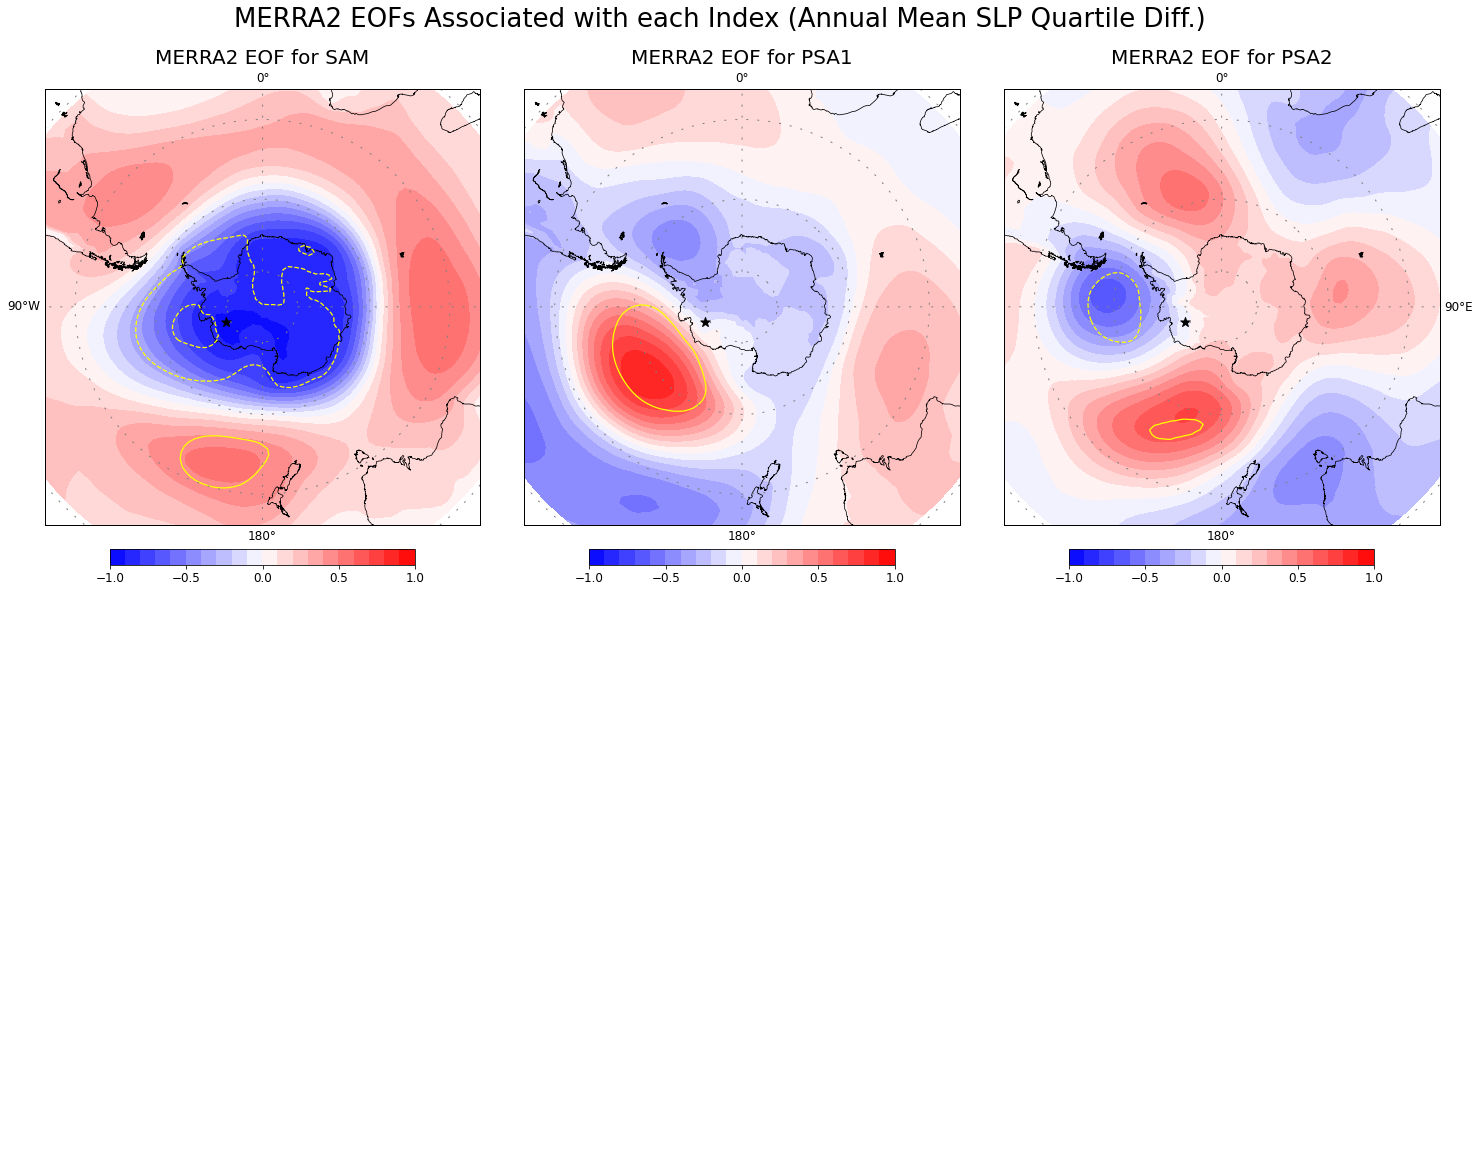

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (Annual Mean SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_Ann_Mean_SLP.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


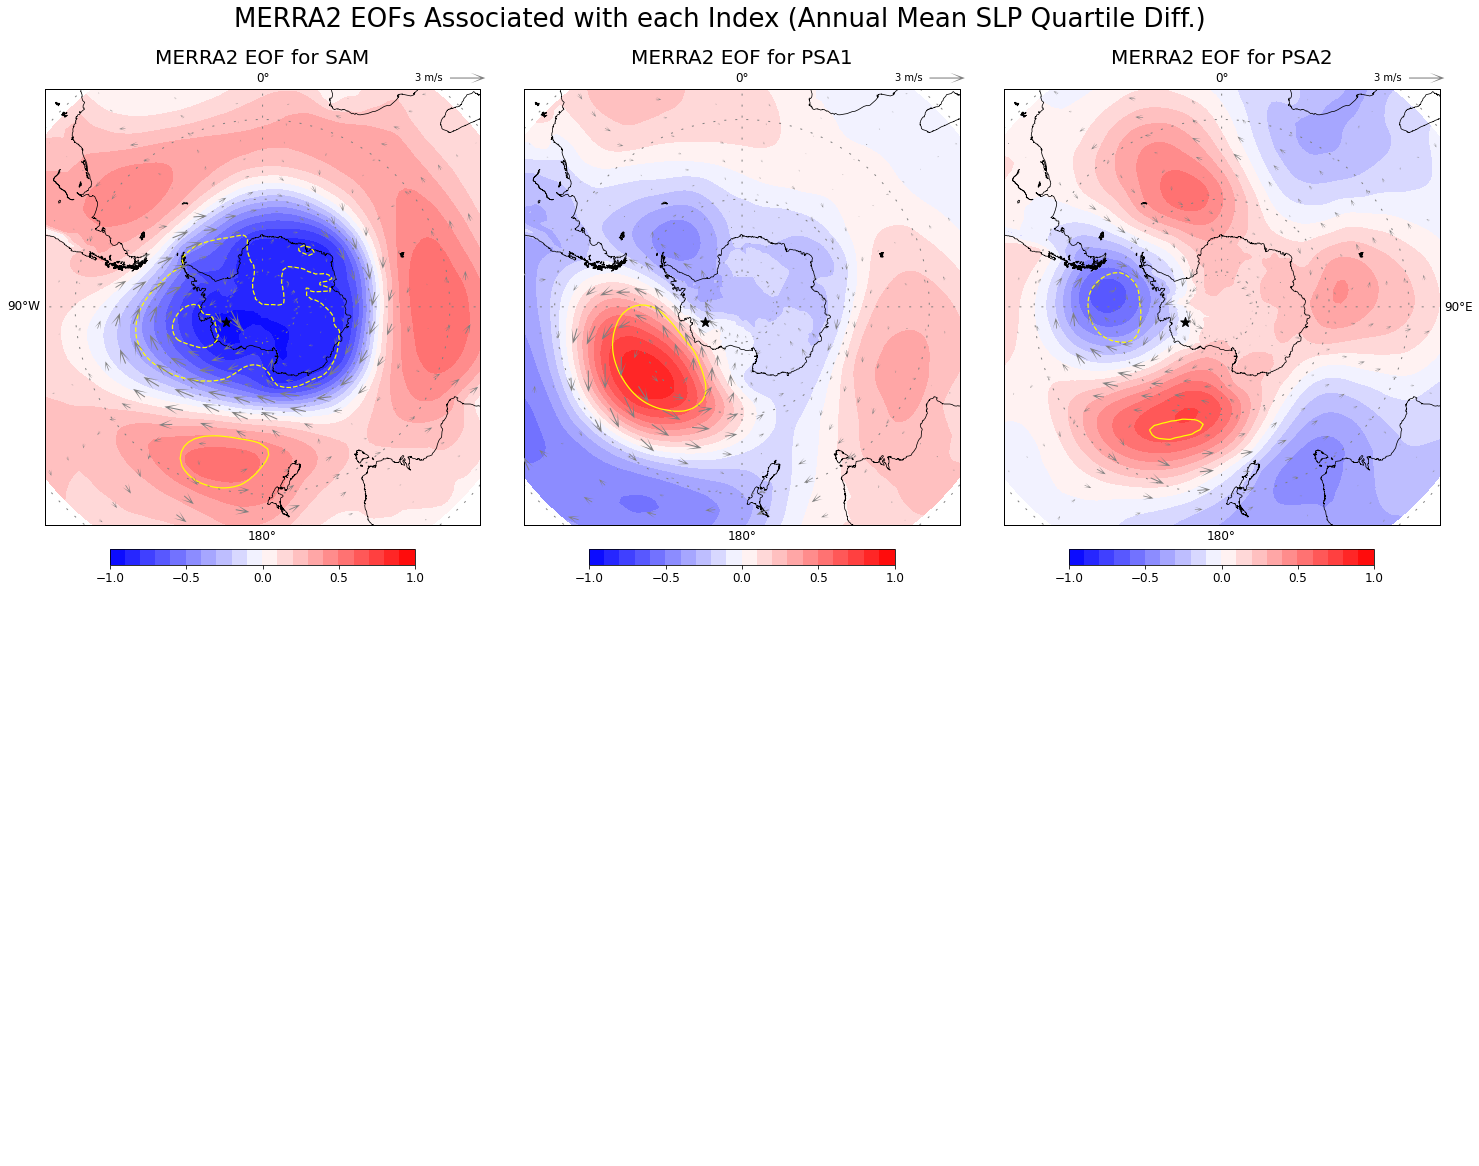

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (Annual Mean SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_ann_mean_u10_wrt_SAM_merra),(diff_ann_mean_v10_wrt_SAM_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')


# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_ann_mean_u10_wrt_PSA1_merra),(diff_ann_mean_v10_wrt_PSA1_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_ann_mean_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_ann_mean_u10_wrt_PSA2_merra),(diff_ann_mean_v10_wrt_PSA2_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_Ann_Mean_SLP_Wind.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

## Gather Vars for plotting JJA Contours

In [75]:
###ctrl
# jja_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, jja_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)

# jja_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, jja_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)

###merra2
jja_slp_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_upper_SAM_detrended_merra.mean(axis=0).values, jja_slp_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_merra, lat_slp_cyclic_w_upper_SAM_merra = np.meshgrid(lons, jja_slp_w_upper_SAM_detrended_merra.coords['lat'].values)

jja_slp_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_lower_SAM_detrended_merra.mean(axis=0).values, jja_slp_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_merra, lat_slp_cyclic_w_lower_SAM_merra = np.meshgrid(lons, jja_slp_w_lower_SAM_detrended_merra.coords['lat'].values)

jja_u10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_upper_SAM_detrended_merra.mean(axis=0).values, jja_u10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_merra, lat_u10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, jja_u10_w_upper_SAM_detrended_merra.coords['lat'].values)

jja_u10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_lower_SAM_detrended_merra.mean(axis=0).values, jja_u10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_merra, lat_u10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, jja_u10_w_lower_SAM_detrended_merra.coords['lat'].values)

jja_v10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_upper_SAM_detrended_merra.mean(axis=0).values, jja_v10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_merra, lat_v10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, jja_v10_w_upper_SAM_detrended_merra.coords['lat'].values)

jja_v10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_lower_SAM_detrended_merra.mean(axis=0).values, jja_v10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_merra, lat_v10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, jja_v10_w_lower_SAM_detrended_merra.coords['lat'].values)

In [76]:
###ctrl
# jja_slp_w_upper_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_upper_PSA1_detrended_ctrl.mean(axis=0).values, jja_slp_w_upper_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA1_ctrl, lat_slp_cyclic_w_upper_PSA1_ctrl = np.meshgrid(lons, jja_slp_w_upper_PSA1_detrended_ctrl.coords['lat'].values)

# jja_slp_w_lower_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_lower_PSA1_detrended_ctrl.mean(axis=0).values, jja_slp_w_lower_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA1_ctrl, lat_slp_cyclic_w_lower_PSA1_ctrl = np.meshgrid(lons, jja_slp_w_lower_PSA1_detrended_ctrl.coords['lat'].values)

###merra2
jja_slp_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_upper_PSA1_detrended_merra.mean(axis=0).values, jja_slp_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA1_merra, lat_slp_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, jja_slp_w_upper_PSA1_detrended_merra.coords['lat'].values)

jja_slp_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_lower_PSA1_detrended_merra.mean(axis=0).values, jja_slp_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA1_merra, lat_slp_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, jja_slp_w_lower_PSA1_detrended_merra.coords['lat'].values)

jja_u10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_upper_PSA1_detrended_merra.mean(axis=0).values, jja_u10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA1_merra, lat_u10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, jja_u10_w_upper_PSA1_detrended_merra.coords['lat'].values)

jja_u10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_lower_PSA1_detrended_merra.mean(axis=0).values, jja_u10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA1_merra, lat_u10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, jja_u10_w_lower_PSA1_detrended_merra.coords['lat'].values)

jja_v10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_upper_PSA1_detrended_merra.mean(axis=0).values, jja_v10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA1_merra, lat_v10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, jja_v10_w_upper_PSA1_detrended_merra.coords['lat'].values)

jja_v10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_lower_PSA1_detrended_merra.mean(axis=0).values, jja_v10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA1_merra, lat_v10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, jja_v10_w_lower_PSA1_detrended_merra.coords['lat'].values)

In [77]:
###ctrl
# jja_slp_w_upper_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_upper_PSA2_detrended_ctrl.mean(axis=0).values, jja_slp_w_upper_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA2_ctrl, lat_slp_cyclic_w_upper_PSA2_ctrl = np.meshgrid(lons, jja_slp_w_upper_PSA2_detrended_ctrl.coords['lat'].values)

# jja_slp_w_lower_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_lower_PSA2_detrended_ctrl.mean(axis=0).values, jja_slp_w_lower_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA2_ctrl, lat_slp_cyclic_w_lower_PSA2_ctrl = np.meshgrid(lons, jja_slp_w_lower_PSA2_detrended_ctrl.coords['lat'].values)

###merra2
jja_slp_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_upper_PSA2_detrended_merra.mean(axis=0).values, jja_slp_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA2_merra, lat_slp_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, jja_slp_w_upper_PSA2_detrended_merra.coords['lat'].values)

jja_slp_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_slp_w_lower_PSA2_detrended_merra.mean(axis=0).values, jja_slp_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA2_merra, lat_slp_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, jja_slp_w_lower_PSA2_detrended_merra.coords['lat'].values)

jja_u10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_upper_PSA2_detrended_merra.mean(axis=0).values, jja_u10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, jja_u10_w_upper_PSA2_detrended_merra.coords['lat'].values)

jja_u10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_u10_w_lower_PSA2_detrended_merra.mean(axis=0).values, jja_u10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA2_merra, lat_u10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, jja_u10_w_lower_PSA2_detrended_merra.coords['lat'].values)

jja_v10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_upper_PSA2_detrended_merra.mean(axis=0).values, jja_v10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA2_merra, lat_v10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, jja_v10_w_upper_PSA2_detrended_merra.coords['lat'].values)

jja_v10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(jja_v10_w_lower_PSA2_detrended_merra.mean(axis=0).values, jja_v10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA2_merra, lat_v10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, jja_v10_w_lower_PSA2_detrended_merra.coords['lat'].values)

In [86]:
jja_slp_w_upper_SAM_detrended_cyclic_merra.shape

(121, 241)

In [78]:
###ctrl
# diff_jja_slp_wrt_SAM_ctrl = jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl
# diff_jja_slp_wrt_PSA1_ctrl = jja_slp_w_upper_PSA1_detrended_cyclic_ctrl - jja_slp_w_lower_PSA1_detrended_cyclic_ctrl
# diff_jja_slp_wrt_PSA2_ctrl = jja_slp_w_upper_PSA2_detrended_cyclic_ctrl - jja_slp_w_lower_PSA2_detrended_cyclic_ctrl

###merra
diff_jja_slp_wrt_SAM_merra = jja_slp_w_upper_SAM_detrended_cyclic_merra - jja_slp_w_lower_SAM_detrended_cyclic_merra
diff_jja_slp_wrt_PSA1_merra = jja_slp_w_upper_PSA1_detrended_cyclic_merra - jja_slp_w_lower_PSA1_detrended_cyclic_merra
diff_jja_slp_wrt_PSA2_merra = jja_slp_w_upper_PSA2_detrended_cyclic_merra - jja_slp_w_lower_PSA2_detrended_cyclic_merra

diff_jja_u10_wrt_SAM_merra = jja_u10_w_upper_SAM_detrended_cyclic_merra - jja_u10_w_lower_SAM_detrended_cyclic_merra
diff_jja_u10_wrt_PSA1_merra = jja_u10_w_upper_PSA1_detrended_cyclic_merra - jja_u10_w_lower_PSA1_detrended_cyclic_merra
diff_jja_u10_wrt_PSA2_merra = jja_u10_w_upper_PSA2_detrended_cyclic_merra - jja_u10_w_lower_PSA2_detrended_cyclic_merra

diff_jja_v10_wrt_SAM_merra = jja_v10_w_upper_SAM_detrended_cyclic_merra - jja_v10_w_lower_SAM_detrended_cyclic_merra
diff_jja_v10_wrt_PSA1_merra = jja_v10_w_upper_PSA1_detrended_cyclic_merra - jja_v10_w_lower_PSA1_detrended_cyclic_merra
diff_jja_v10_wrt_PSA2_merra = jja_v10_w_upper_PSA2_detrended_cyclic_merra - jja_v10_w_lower_PSA2_detrended_cyclic_merra

In [79]:
# ###ctrl
# lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
# x_slp, y_slp = m(lon_slp, lat_slp)

###merra2
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_merra,lat_slp_cyclic_w_upper_SAM_merra
x_slp, y_slp = m(lon_slp, lat_slp)

lon_wind, lat_wind = lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra
x_wind, y_wind = m(lon_wind, lat_wind)

In [80]:
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_merra),levels_contour,linewidths=1.25,colors='gray')

In [81]:
# levels_contour_diff = [-9,-7.5,-6,-4.5,-3,-1.5,1.5,3,4.5,6,7.5,9]
levels_contour_diff = [-15,-12,-9,-6,-3,3,6,9,12,15]

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


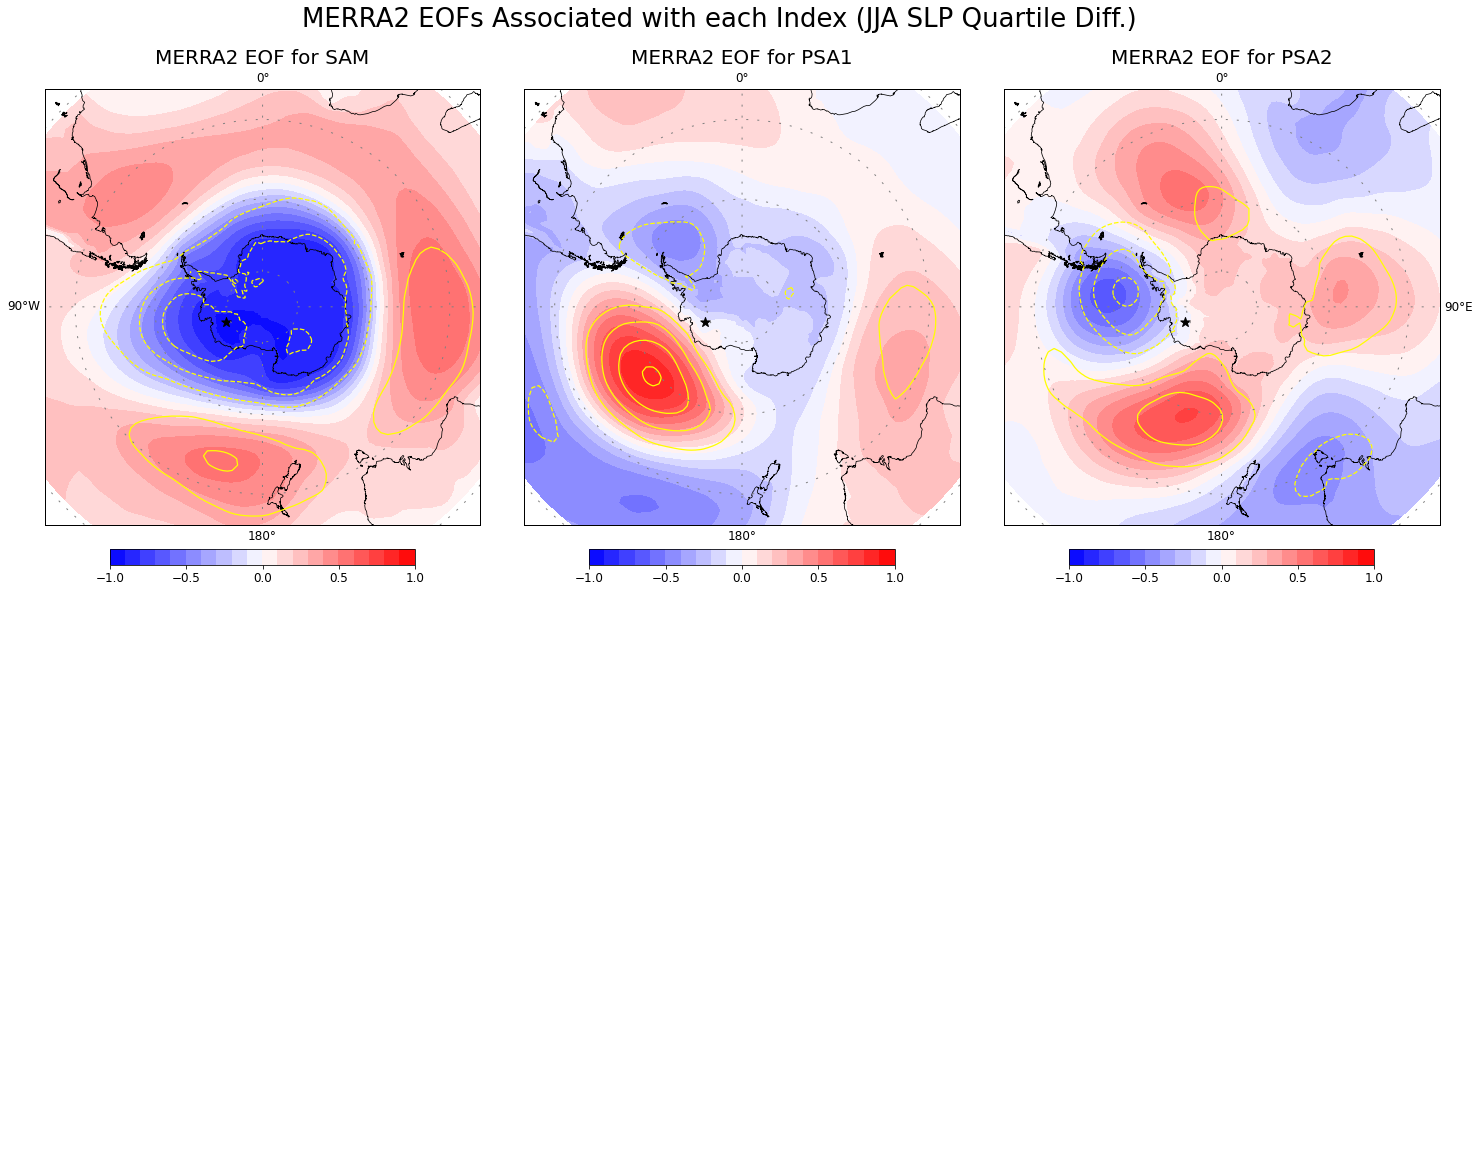

In [108]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (JJA SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_JJA_Mean_SLP.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


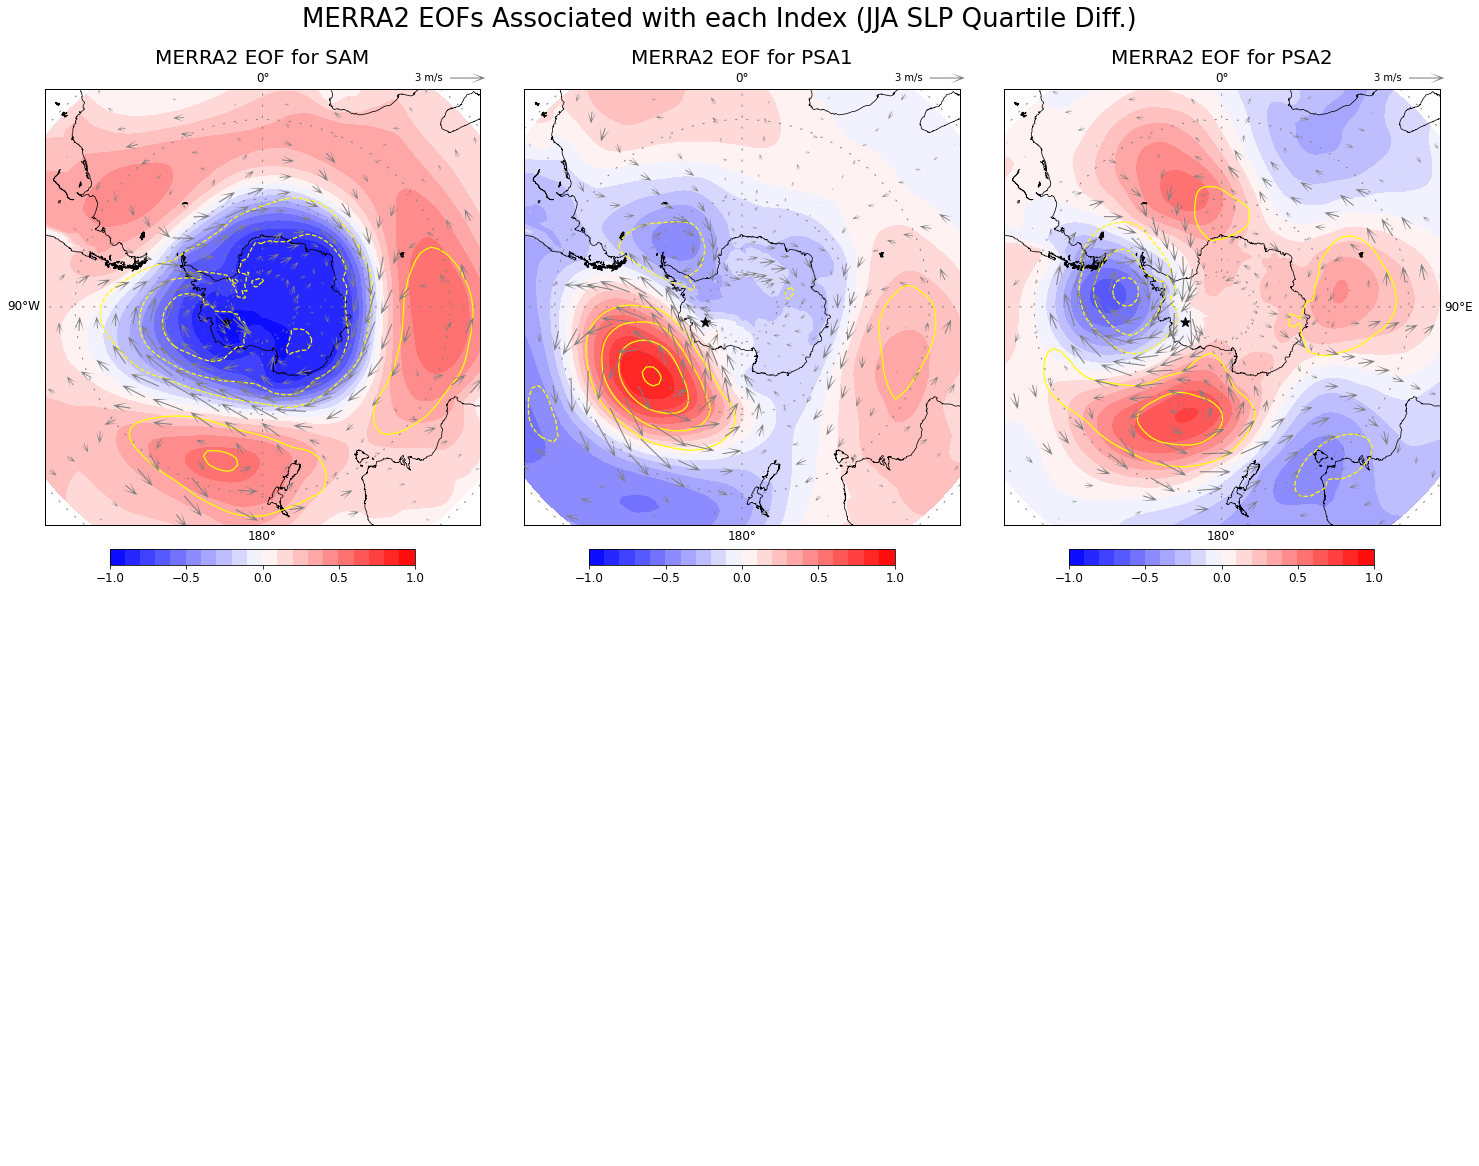

In [113]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (JJA SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_jja_u10_wrt_SAM_merra),(diff_jja_v10_wrt_SAM_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_jja_u10_wrt_PSA1_merra),(diff_jja_v10_wrt_PSA1_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_jja_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

urot,vrot,x,y = m.rotate_vector((diff_jja_u10_wrt_PSA2_merra),(diff_jja_v10_wrt_PSA2_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_JJA_Mean_SLP_Wind.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

## Gather Vars for plotting DJF Contours

In [85]:
###ctrl
# djf_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, djf_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)

# djf_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, djf_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)

###merra2
djf_slp_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_upper_SAM_detrended_merra.mean(axis=0).values, djf_slp_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_merra, lat_slp_cyclic_w_upper_SAM_merra = np.meshgrid(lons, djf_slp_w_upper_SAM_detrended_merra.coords['lat'].values)

djf_slp_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_lower_SAM_detrended_merra.mean(axis=0).values, djf_slp_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_merra, lat_slp_cyclic_w_lower_SAM_merra = np.meshgrid(lons, djf_slp_w_lower_SAM_detrended_merra.coords['lat'].values)

djf_u10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_upper_SAM_detrended_merra.mean(axis=0).values, djf_u10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_merra, lat_u10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, djf_u10_w_upper_SAM_detrended_merra.coords['lat'].values)

djf_u10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_lower_SAM_detrended_merra.mean(axis=0).values, djf_u10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_merra, lat_u10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, djf_u10_w_lower_SAM_detrended_merra.coords['lat'].values)

djf_v10_w_upper_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_upper_SAM_detrended_merra.mean(axis=0).values, djf_v10_w_upper_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_merra, lat_v10_cyclic_w_upper_SAM_merra = np.meshgrid(lons, djf_v10_w_upper_SAM_detrended_merra.coords['lat'].values)

djf_v10_w_lower_SAM_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_lower_SAM_detrended_merra.mean(axis=0).values, djf_v10_w_lower_SAM_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_merra, lat_v10_cyclic_w_lower_SAM_merra = np.meshgrid(lons, djf_v10_w_lower_SAM_detrended_merra.coords['lat'].values)

In [86]:
###ctrl
# djf_slp_w_upper_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_upper_PSA1_detrended_ctrl.mean(axis=0).values, djf_slp_w_upper_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA1_ctrl, lat_slp_cyclic_w_upper_PSA1_ctrl = np.meshgrid(lons, djf_slp_w_upper_PSA1_detrended_ctrl.coords['lat'].values)

# djf_slp_w_lower_PSA1_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_lower_PSA1_detrended_ctrl.mean(axis=0).values, djf_slp_w_lower_PSA1_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA1_ctrl, lat_slp_cyclic_w_lower_PSA1_ctrl = np.meshgrid(lons, djf_slp_w_lower_PSA1_detrended_ctrl.coords['lat'].values)

###merra2
djf_slp_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_upper_PSA1_detrended_merra.mean(axis=0).values, djf_slp_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA1_merra, lat_slp_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, djf_slp_w_upper_PSA1_detrended_merra.coords['lat'].values)

djf_slp_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_lower_PSA1_detrended_merra.mean(axis=0).values, djf_slp_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA1_merra, lat_slp_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, djf_slp_w_lower_PSA1_detrended_merra.coords['lat'].values)

djf_u10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_upper_PSA1_detrended_merra.mean(axis=0).values, djf_u10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA1_merra, lat_u10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, djf_u10_w_upper_PSA1_detrended_merra.coords['lat'].values)

djf_u10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_lower_PSA1_detrended_merra.mean(axis=0).values, djf_u10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA1_merra, lat_u10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, djf_u10_w_lower_PSA1_detrended_merra.coords['lat'].values)

djf_v10_w_upper_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_upper_PSA1_detrended_merra.mean(axis=0).values, djf_v10_w_upper_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA1_merra, lat_v10_cyclic_w_upper_PSA1_merra = np.meshgrid(lons, djf_v10_w_upper_PSA1_detrended_merra.coords['lat'].values)

djf_v10_w_lower_PSA1_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_lower_PSA1_detrended_merra.mean(axis=0).values, djf_v10_w_lower_PSA1_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA1_merra, lat_v10_cyclic_w_lower_PSA1_merra = np.meshgrid(lons, djf_v10_w_lower_PSA1_detrended_merra.coords['lat'].values)

In [87]:
###ctrl
# djf_slp_w_upper_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_upper_PSA2_detrended_ctrl.mean(axis=0).values, djf_slp_w_upper_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_upper_PSA2_ctrl, lat_slp_cyclic_w_upper_PSA2_ctrl = np.meshgrid(lons, djf_slp_w_upper_PSA2_detrended_ctrl.coords['lat'].values)

# djf_slp_w_lower_PSA2_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_lower_PSA2_detrended_ctrl.mean(axis=0).values, djf_slp_w_lower_PSA2_detrended_ctrl.coords['lon'].values, axis=-1)
# lon_slp_cyclic_w_lower_PSA2_ctrl, lat_slp_cyclic_w_lower_PSA2_ctrl = np.meshgrid(lons, djf_slp_w_lower_PSA2_detrended_ctrl.coords['lat'].values)

###merra2
djf_slp_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_upper_PSA2_detrended_merra.mean(axis=0).values, djf_slp_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_PSA2_merra, lat_slp_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, djf_slp_w_upper_PSA2_detrended_merra.coords['lat'].values)

djf_slp_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_slp_w_lower_PSA2_detrended_merra.mean(axis=0).values, djf_slp_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_PSA2_merra, lat_slp_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, djf_slp_w_lower_PSA2_detrended_merra.coords['lat'].values)

djf_u10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_upper_PSA2_detrended_merra.mean(axis=0).values, djf_u10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, djf_u10_w_upper_PSA2_detrended_merra.coords['lat'].values)

djf_u10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_u10_w_lower_PSA2_detrended_merra.mean(axis=0).values, djf_u10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_PSA2_merra, lat_u10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, djf_u10_w_lower_PSA2_detrended_merra.coords['lat'].values)

djf_v10_w_upper_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_upper_PSA2_detrended_merra.mean(axis=0).values, djf_v10_w_upper_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_PSA2_merra, lat_v10_cyclic_w_upper_PSA2_merra = np.meshgrid(lons, djf_v10_w_upper_PSA2_detrended_merra.coords['lat'].values)

djf_v10_w_lower_PSA2_detrended_cyclic_merra, lons = add_cyclic_point(djf_v10_w_lower_PSA2_detrended_merra.mean(axis=0).values, djf_v10_w_lower_PSA2_detrended_merra.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_PSA2_merra, lat_v10_cyclic_w_lower_PSA2_merra = np.meshgrid(lons, djf_v10_w_lower_PSA2_detrended_merra.coords['lat'].values)

In [88]:
djf_slp_w_upper_SAM_detrended_cyclic_merra.shape

(121, 241)

In [89]:
###ctrl
# diff_djf_slp_wrt_SAM_ctrl = djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl
# diff_djf_slp_wrt_PSA1_ctrl = djf_slp_w_upper_PSA1_detrended_cyclic_ctrl - djf_slp_w_lower_PSA1_detrended_cyclic_ctrl
# diff_djf_slp_wrt_PSA2_ctrl = djf_slp_w_upper_PSA2_detrended_cyclic_ctrl - djf_slp_w_lower_PSA2_detrended_cyclic_ctrl

###merra
diff_djf_slp_wrt_SAM_merra = djf_slp_w_upper_SAM_detrended_cyclic_merra - djf_slp_w_lower_SAM_detrended_cyclic_merra
diff_djf_slp_wrt_PSA1_merra = djf_slp_w_upper_PSA1_detrended_cyclic_merra - djf_slp_w_lower_PSA1_detrended_cyclic_merra
diff_djf_slp_wrt_PSA2_merra = djf_slp_w_upper_PSA2_detrended_cyclic_merra - djf_slp_w_lower_PSA2_detrended_cyclic_merra

diff_djf_u10_wrt_SAM_merra = djf_u10_w_upper_SAM_detrended_cyclic_merra - djf_u10_w_lower_SAM_detrended_cyclic_merra
diff_djf_u10_wrt_PSA1_merra = djf_u10_w_upper_PSA1_detrended_cyclic_merra - djf_u10_w_lower_PSA1_detrended_cyclic_merra
diff_djf_u10_wrt_PSA2_merra = djf_u10_w_upper_PSA2_detrended_cyclic_merra - djf_u10_w_lower_PSA2_detrended_cyclic_merra

diff_djf_v10_wrt_SAM_merra = djf_v10_w_upper_SAM_detrended_cyclic_merra - djf_v10_w_lower_SAM_detrended_cyclic_merra
diff_djf_v10_wrt_PSA1_merra = djf_v10_w_upper_PSA1_detrended_cyclic_merra - djf_v10_w_lower_PSA1_detrended_cyclic_merra
diff_djf_v10_wrt_PSA2_merra = djf_v10_w_upper_PSA2_detrended_cyclic_merra - djf_v10_w_lower_PSA2_detrended_cyclic_merra

In [90]:
# ###ctrl
# lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
# x_slp, y_slp = m(lon_slp, lat_slp)

###merra2
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_merra,lat_slp_cyclic_w_upper_SAM_merra
x_slp, y_slp = m(lon_slp, lat_slp)

lon_wind, lat_wind = lon_u10_cyclic_w_upper_PSA2_merra, lat_u10_cyclic_w_upper_PSA2_merra
x_wind, y_wind = m(lon_wind, lat_wind)

In [91]:
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_merra),levels_contour,linewidths=1.25,colors='gray')

In [92]:
# levels_contour_diff = [-9,-7.5,-6,-4.5,-3,-1.5,1.5,3,4.5,6,7.5,9]
levels_contour_diff = [-15,-12,-9,-6,-3,3,6,9,12,15]

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


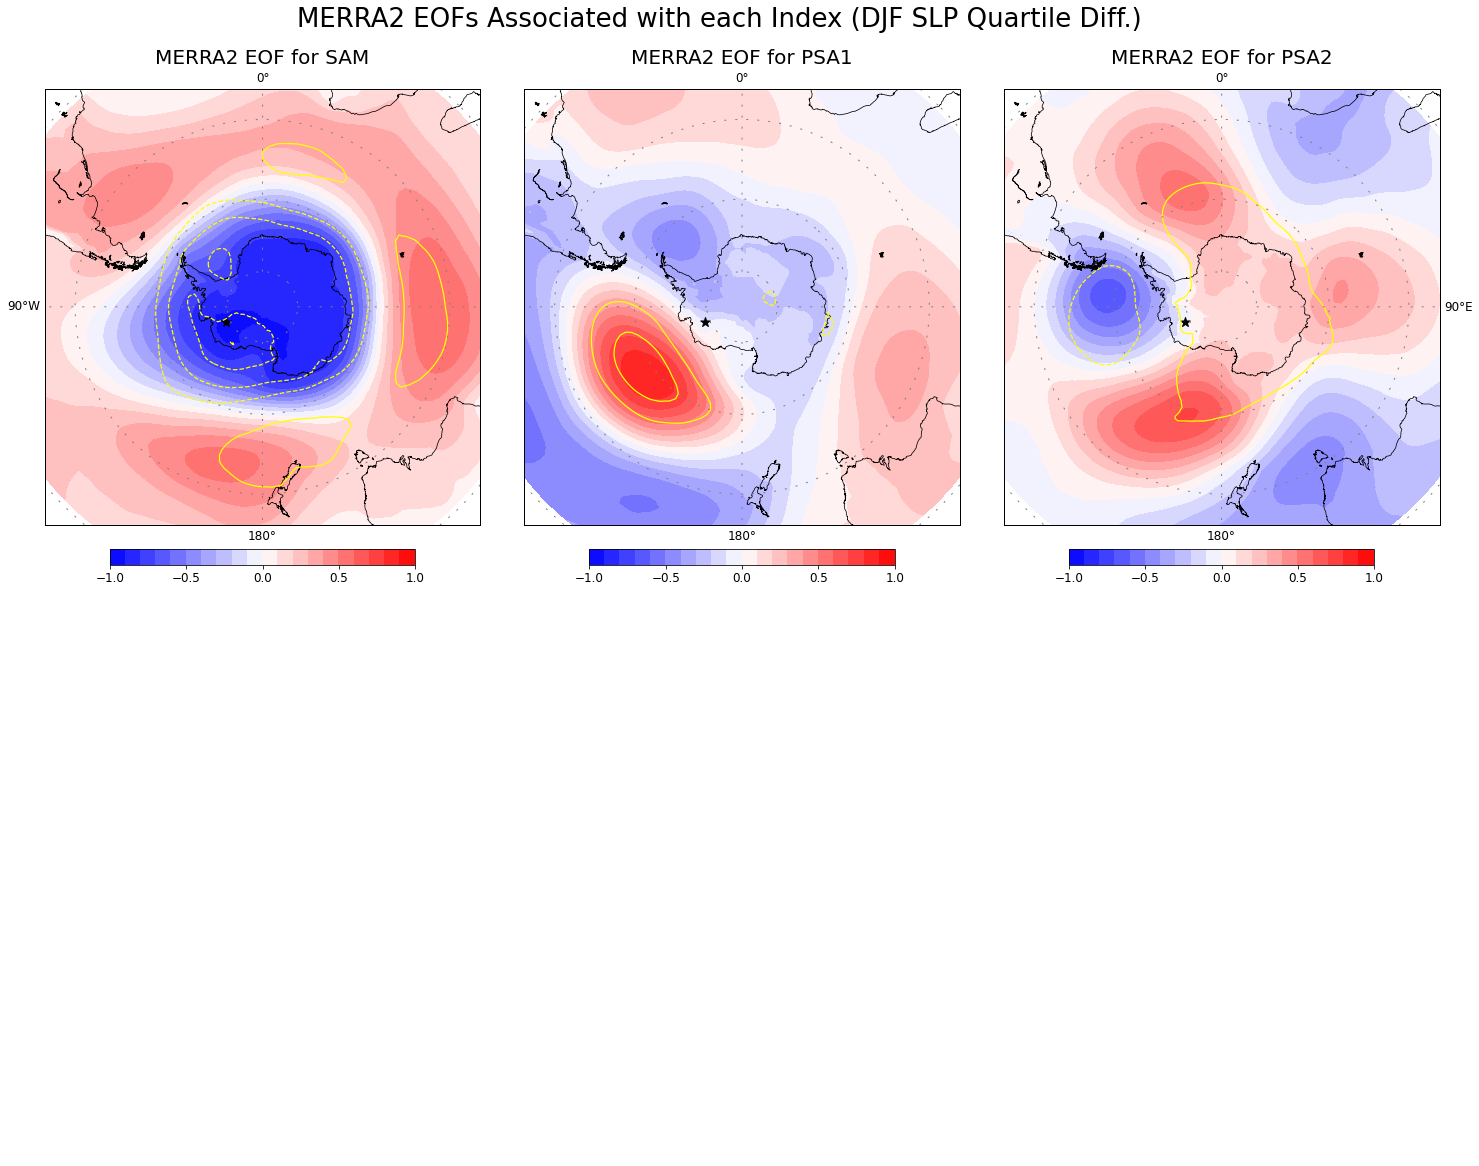

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (DJF SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_DJF_SLP.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()

(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)
(47, 241)
(47, 241)
(47, 240)


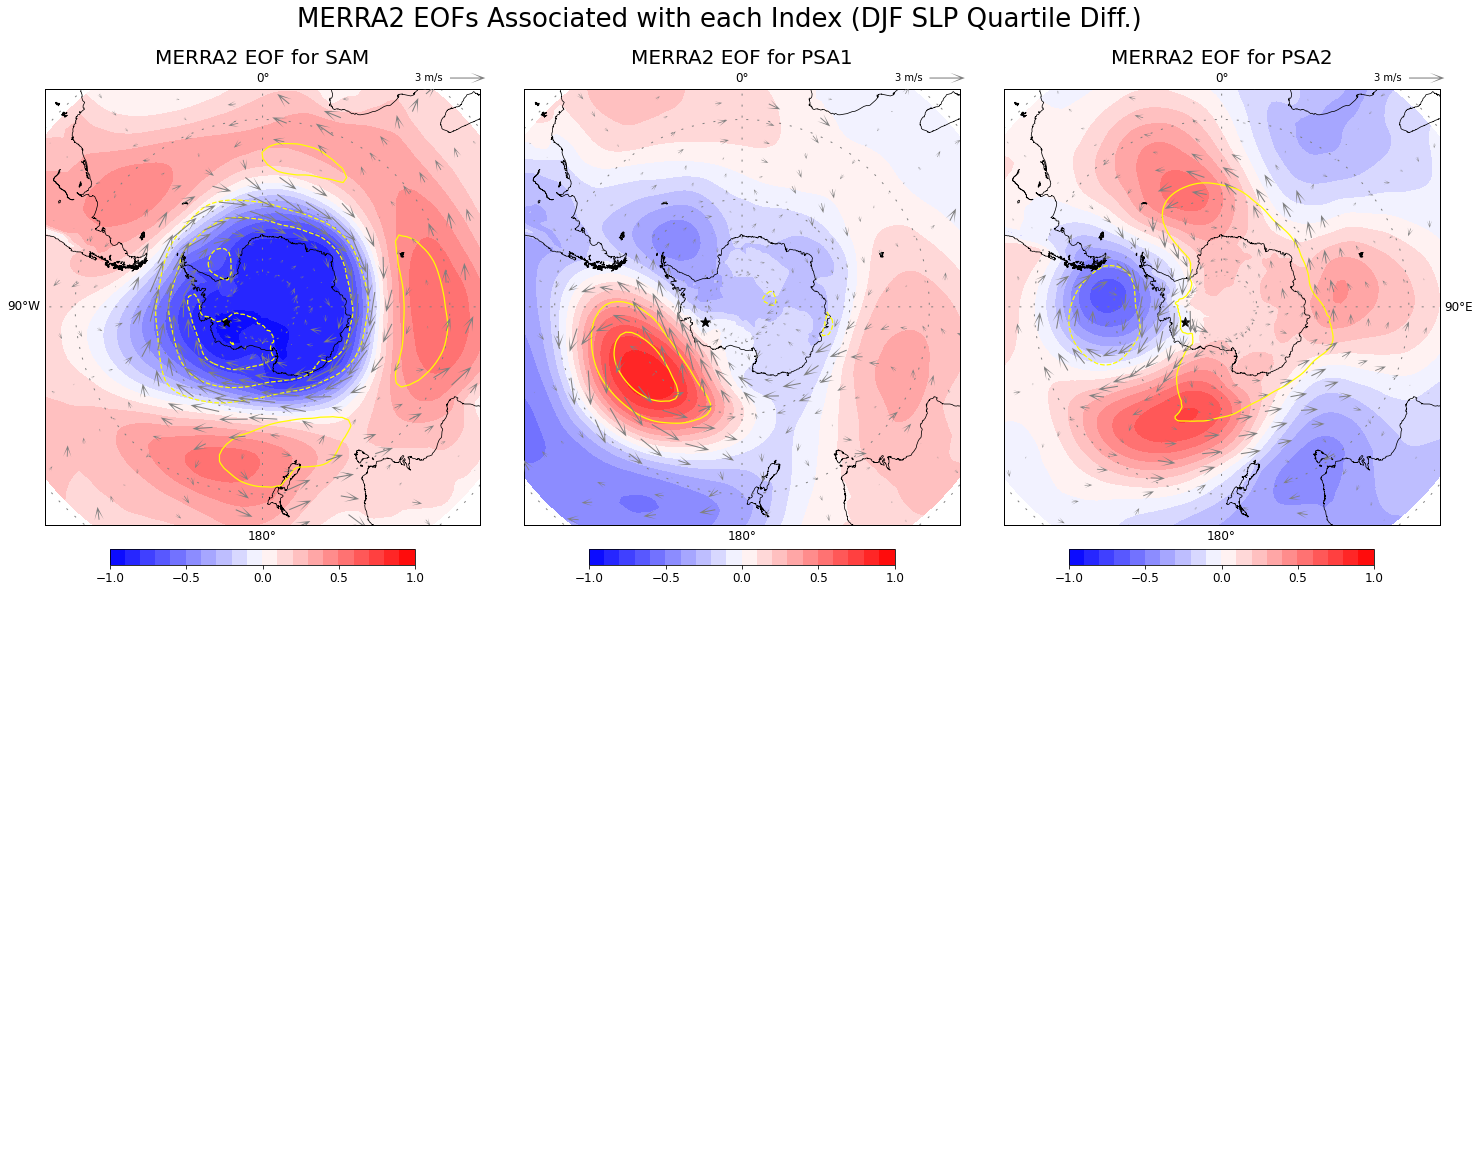

In [114]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('MERRA2 EOFs Associated with each Index (DJF SLP Quartile Diff.)', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# parallels = np.arange(-80,-1,20)
meridians2 = np.arange(0,360,90.)
# meridians2 = [-70.,20.,145]
levels_shade = np.arange(-1,1.1,0.1)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,sam_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_SAM_merra),levels_contour_diff,linewidths=1.25,colors='yellow', zorder=5)

urot,vrot,x,y = m.rotate_vector((diff_djf_u10_wrt_SAM_merra),(diff_djf_v10_wrt_SAM_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for SAM',y=1.045,fontsize=20)



plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,False,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa1_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_PSA1_merra),levels_contour_diff,linewidths=1.25,colors='yellow', zorder=5)

urot,vrot,x,y = m.rotate_vector((diff_djf_u10_wrt_PSA1_merra),(diff_djf_v10_wrt_PSA1_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA1',y=1.045,fontsize=20)




plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_merra,lat_cyclic_merra

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 9],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[False,True,True,True],dashes=[2, 9],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(sam_eof_merra.shape)
CS = m.contourf(x,y,psa2_eof_cyclic_merra, levels_shade, cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='neither')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-1,1.5,0.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x_slp,y_slp,(diff_djf_slp_wrt_PSA2_merra),levels_contour_diff,linewidths=1.25,colors='yellow', zorder=5)

urot,vrot,x,y = m.rotate_vector((diff_djf_u10_wrt_PSA2_merra),(diff_djf_v10_wrt_PSA2_merra),lon_wind,lat_wind,returnxy=True)
Q = m.quiver(x[0:-5:3,5::10],y[0:-5:3,5::10],(-1)*urot[0:-5:3,5::10],(-1)*vrot[0:-5:3,5::10],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='gray', zorder=10)
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MERRA2 EOF for PSA2',y=1.045,fontsize=20)



ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

                
                
plt.savefig(FIG_PATH+'/Figure_MERRA2_EOFs_DJF_SLP_Wind.ps',bbox_inches='tight', pad_inches=0.05)                
                
plt.show()